In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(82, 175305)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]#
# [col for col in data_loaded.columns if 'Footprint' in col ]

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
#data['KNe single model'] # data['KNe ZTF simple']

In [7]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [8]:
mag_data

g          i          r          u  \
baseline_v2.0_10yrs          26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs          26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs          26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs          26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs          26.678103  26.295888  26.807880  25.622696   
...                                ...        ...        ...        ...   
weather_cloudso35v3.4_10yrs  26.771657  26.465085  26.937286  25.312279   
weather_cloudso36v3.4_10yrs  26.794242  26.463970  26.939642  25.311388   
weather_cloudso4v3.4_10yrs   26.821078  26.479928  26.967275  25.360355   
weather_cloudso6v3.4_10yrs   26.827587  26.494546  26.972935  25.357166   
weather_cloudso8v3.4_10yrs   26.787828  26.473255  26.952642  25.329369   

                                     y          z  
baseline_v2.0_10yrs          24.762720  25.510379  
baseline_v2.1_10yrs          24.728145  25.486640  
baseline_v2.2_10yrs          24.782743  25.581317  
baseline_v3.0_10yrs          24.756955  25.524781  
baseline_v3.2_10yrs          24.766647  25.586860  
...                                ...        ...  
weather_cloudso35v3.4_10yrs  24.807737  25.749097  
weather_cloudso36v3.4_10yrs  24.808025  25.751439  
weather_cloudso4v3.4_10yrs   24.830049  25.768793  
weather_cloudso6v3.4_10yrs   24.837374  25.779175  
weather_cloudso8v3.4_10yrs   24.819896  25.767812  

[82 rows x 6 columns]

In [9]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS  N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs           638.253284  586.826209   974.231557   
baseline_v2.1_10yrs           548.479625  545.669910   875.981802   
baseline_v2.2_10yrs           708.239238  685.202422  1067.553931   
baseline_v3.0_10yrs           955.159293  799.584601  1266.961769   
baseline_v3.2_10yrs           971.481238  868.593513  1528.851192   
...                                  ...         ...          ...   
weather_cloudso35v3.4_10yrs   958.375661  810.059046  1443.785653   
weather_cloudso36v3.4_10yrs   963.413804  792.456726  1389.607805   
weather_cloudso4v3.4_10yrs    987.870601  861.180684  1644.586062   
weather_cloudso6v3.4_10yrs    985.701377  874.067454  1655.599953   
weather_cloudso8v3.4_10yrs    979.237401  812.825309  1468.876553   

                             N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v2.0_10yrs            684.401547    611.229060     0.503926   
baseline_v2.1_10yrs            636.634918    520.071105     0.496150   
baseline_v2.2_10yrs            674.561648    611.247120     0.493897   
baseline_v3.0_10yrs            688.808879    726.491723     0.503734   
baseline_v3.2_10yrs            844.740564    840.405268     0.510969   
...                                   ...           ...          ...   
weather_cloudso35v3.4_10yrs    760.199198    776.209916     0.549413   
weather_cloudso36v3.4_10yrs    819.411099    861.182224     0.546436   
weather_cloudso4v3.4_10yrs     841.755851    895.651192     0.540408   
weather_cloudso6v3.4_10yrs     900.338056    903.149525     0.544132   
weather_cloudso8v3.4_10yrs     799.791185    827.726316     0.544271   

                             zlim ECDFS  zlim EDFS  zlim ELAISS1  \
baseline_v2.0_10yrs            0.485978   0.481621      0.508870   
baseline_v2.1_10yrs            0.484905   0.474738      0.501027   
baseline_v2.2_10yrs            0.495572   0.466223      0.488264   
baseline_v3.0_10yrs            0.521961   0.464010      0.500330   
baseline_v3.2_10yrs            0.550142   0.486932      0.516296   
...                                 ...        ...           ...   
weather_cloudso35v3.4_10yrs    0.536616   0.489019      0.502263   
weather_cloudso36v3.4_10yrs    0.545966   0.506047      0.506173   
weather_cloudso4v3.4_10yrs     0.562153   0.508139      0.522749   
weather_cloudso6v3.4_10yrs     0.555084   0.504323      0.524751   
weather_cloudso8v3.4_10yrs     0.563396   0.500781      0.488403   

                             zlim XMM_LSS  ...  Kne EDFS  Kne ELAISS1  \
baseline_v2.0_10yrs              0.490990  ...     365.0        423.0   
baseline_v2.1_10yrs              0.480094  ...     373.0        384.0   
baseline_v2.2_10yrs              0.484132  ...     425.0        370.0   
baseline_v3.0_10yrs              0.484669  ...     428.0        405.0   
baseline_v3.2_10yrs              0.502590  ...     537.0        455.0   
...                                   ...  ...       ...          ...   
weather_cloudso35v3.4_10yrs      0.503217  ...     547.0        490.0   
weather_cloudso36v3.4_10yrs      0.511697  ...     563.0        520.0   
weather_cloudso4v3.4_10yrs       0.519459  ...     615.0        530.0   
weather_cloudso6v3.4_10yrs       0.517615  ...     638.0        521.0   
weather_cloudso8v3.4_10yrs       0.504443  ...     585.0        499.0   

                             Kne WFD  Kne XMM_LSS  N COSMOS  N ECDFS  N EDFS  \
baseline_v2.0_10yrs            298.0        317.0    8937.5   9264.0  5497.0   
baseline_v2.1_10yrs            289.0        325.0    8900.0   9166.5  5506.0   
baseline_v2.2_10yrs            327.0        304.0    9853.0   9663.0  6150.0   
baseline_v3.0_10yrs            339.0        340.0   18716.5  10606.5  6668.0   
baseline_v3.2_10yrs            392.0        419.0   19496.5  10806.5  6800.0   
...                              ...          ...       ...      ...     ...   
weather_cloudso35v3.4_10yrs    414.0        427.0   19172.0   9867.0  6144.0   
w

In [10]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  \
baseline_v2.0_10yrs          0.559565  0.096983   2.681121  0.501515   
baseline_v2.1_10yrs          0.601110  0.097077   2.961440  0.621392   
baseline_v2.2_10yrs          0.633655  0.187066   3.622465  0.399776   
baseline_v3.0_10yrs          0.257192  0.257425   3.984706  0.213736   
baseline_v3.2_10yrs          0.140020  0.100247   3.084814  0.605912   
...                               ...       ...        ...       ...   
weather_cloudso35v3.4_10yrs  0.167343  0.106728   3.968014  0.189211   
weather_cloudso36v3.4_10yrs  0.207861  0.115028   3.835128  0.202546   
weather_cloudso4v3.4_10yrs   0.171632  0.132513   3.504220  0.149158   
weather_cloudso6v3.4_10yrs   0.176202  0.111997   4.167529  0.170187   
weather_cloudso8v3.4_10yrs   0.173358  0.122535   4.165571  0.225859   

                             gaps g 7  gaps g 24  gaps r 3  gaps r 7  \
baseline_v2.0_10yrs          0.060381   4.151443  2.579755  0.452371   
baseline_v2.1_10yrs          0.080291   4.104024  2.708024  0.389565   
baseline_v2.2_10yrs          0.051569   4.466172  1.834849  0.314636   
baseline_v3.0_10yrs          0.363687   3.787056  1.069054  1.779876   
baseline_v3.2_10yrs          0.540215   3.727001  1.198583  0.843055   
...                               ...        ...       ...       ...   
weather_cloudso35v3.4_10yrs  0.155966   4.525575  1.926656  1.533035   
weather_cloudso36v3.4_10yrs  0.161561   4.658041  1.929920  1.493729   
weather_cloudso4v3.4_10yrs   0.128922   4.527346  1.922553  1.473353   
weather_cloudso6v3.4_10yrs   0.157551   4.790787  1.961953  1.437497   
weather_cloudso8v3.4_10yrs   0.149765   4.368583  1.861099  1.570290   

                             gaps r 24  gaps i 3  gaps i 7  gaps i 24  \
baseline_v2.0_10yrs          17.055252  2.086213  0.422810  15.289504   
baseline_v2.1_10yrs          18.103231  2.217187  0.366019  16.026064   
baseline_v2.2_10yrs          19.672775  1.433580  0.276449  16.984520   
baseline_v3.0_10yrs          20.989882  1.293328  1.973516  18.047932   
baseline_v3.2_10yrs          20.776752  2.040891  1.196717  19.389239   
...                                ...       ...       ...        ...   
weather_cloudso35v3.4_10yrs  24.743694  1.583811  0.997249  21.327319   
weather_cloudso36v3.4_10yrs  24.818343  1.665408  0.999580  21.692078   
weather_cloudso4v3.4_10yrs   25.596494  1.636966  1.119317  22.541754   
weather_cloudso6v3.4_10yrs   26.472374  1.699772  1.080058  22.740243   
weather_cloudso8v3.4_10yrs   24.805194  1.643074  1.025365  21.089663   

                             gaps z 3  gaps z 7  gaps z 24  gaps y 3  \
baseline_v2.0_10yrs          2.832937  0.465706  18.134005  2.181890   
baseline_v2.1_10yrs          3.008206  0.484776  18.327179  2.477409   
baseline_v2.2_10yrs          2.238075  0.408775  20.773395  1.377629   
baseline_v3.0_10yrs          1.569590  1.366578  22.387886  0.725976   
baseline_v3.2_10yrs          1.162540  0.734229  16.713013  1.363501   
...                               ...       ...        ...       ...   
weather_cloudso35v3.4_10yrs  1.076654  0.655849  19.372966  1.494568   
weather_cloudso36v3.4_10yrs  1.269315  0.736187  19.226838  1.378048   
weather_cloudso4v3.4_10yrs   1.332447  0.733529  19.169115  1.408449   
weather_cloudso6v3.4_10yrs   1.368397  0.914207  19.797781  1.745372   
weather_cloudso8v3.4_10yrs   1.279946  0.825757  18.553224  1.417774   

                             gaps y 7  gaps y 24  
baseline_v2.0_10yrs          0.218119  10.919662  
baseline_v2.1_10yrs          0.206229  10.257798  
baseline_v2.2_10yrs          0.186833   8.640323  
baseline_v3.0_10yrs          0.211312   9.392083  
baseline_v3.2_10yrs          0.541941  13.219471  
...                               ...        ...  
weather_cloudso35v3.4_10yrs  0.557234  16.039586  
weather_cloudso36v3.4_10yrs  0.516016  16.237842  
weather_cloudso4v3.4_10yrs   0.618874  16.702942  
weather_cloudso6v3.4_10yrs   0.648203  16.91541

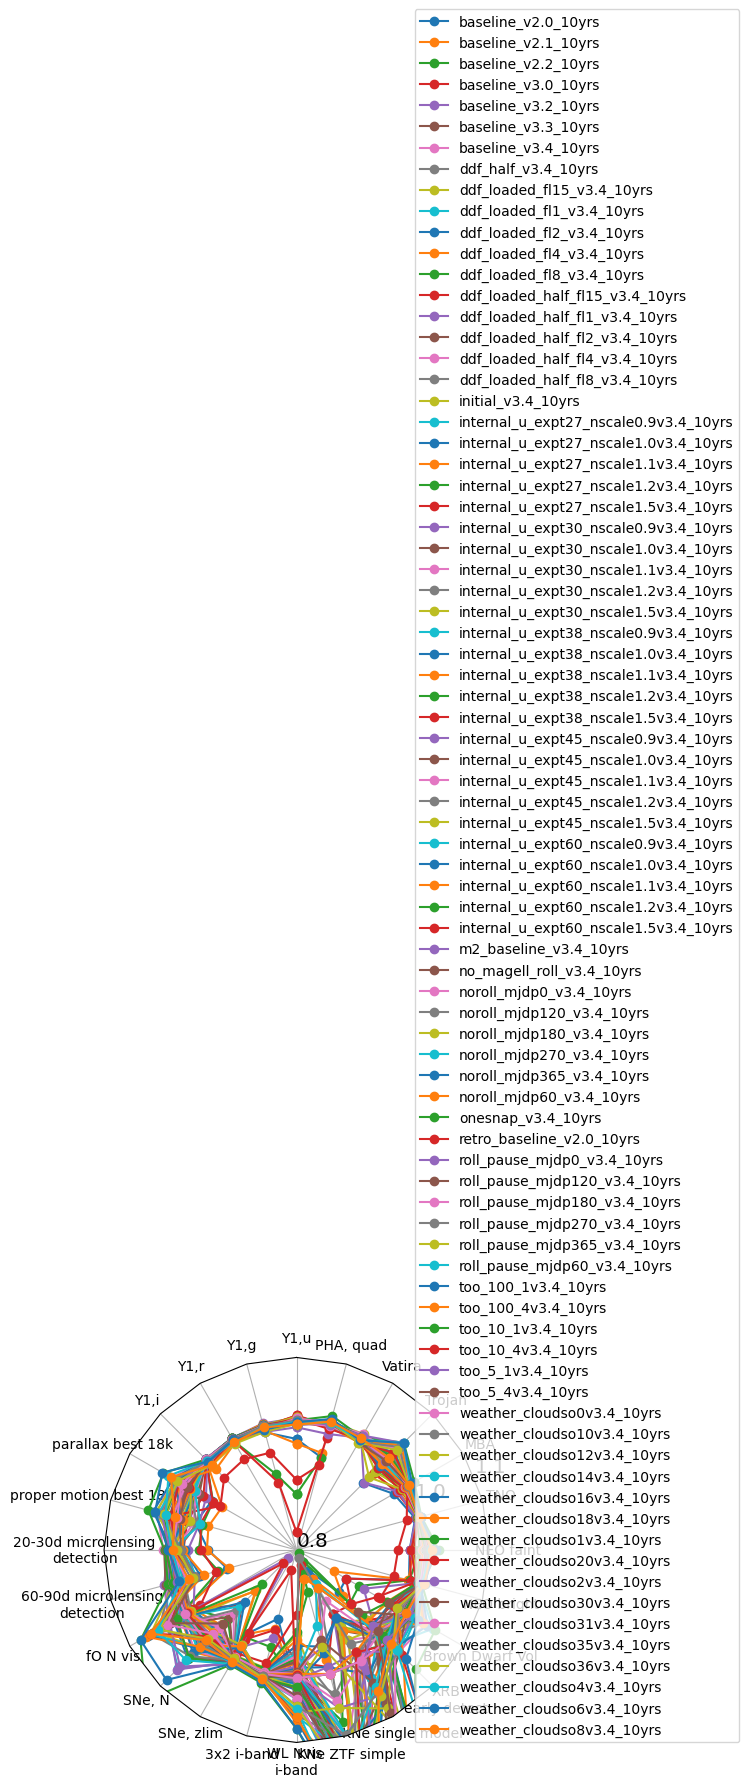

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

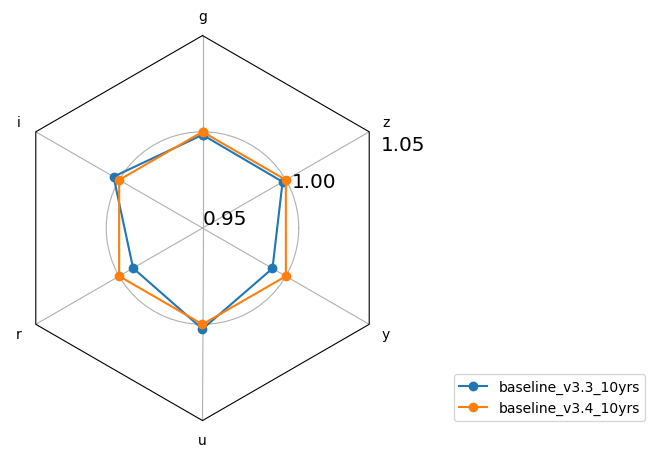

In [12]:
runs = ['baseline_v3.3_10yrs', 'baseline_v3.4_10yrs' ]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

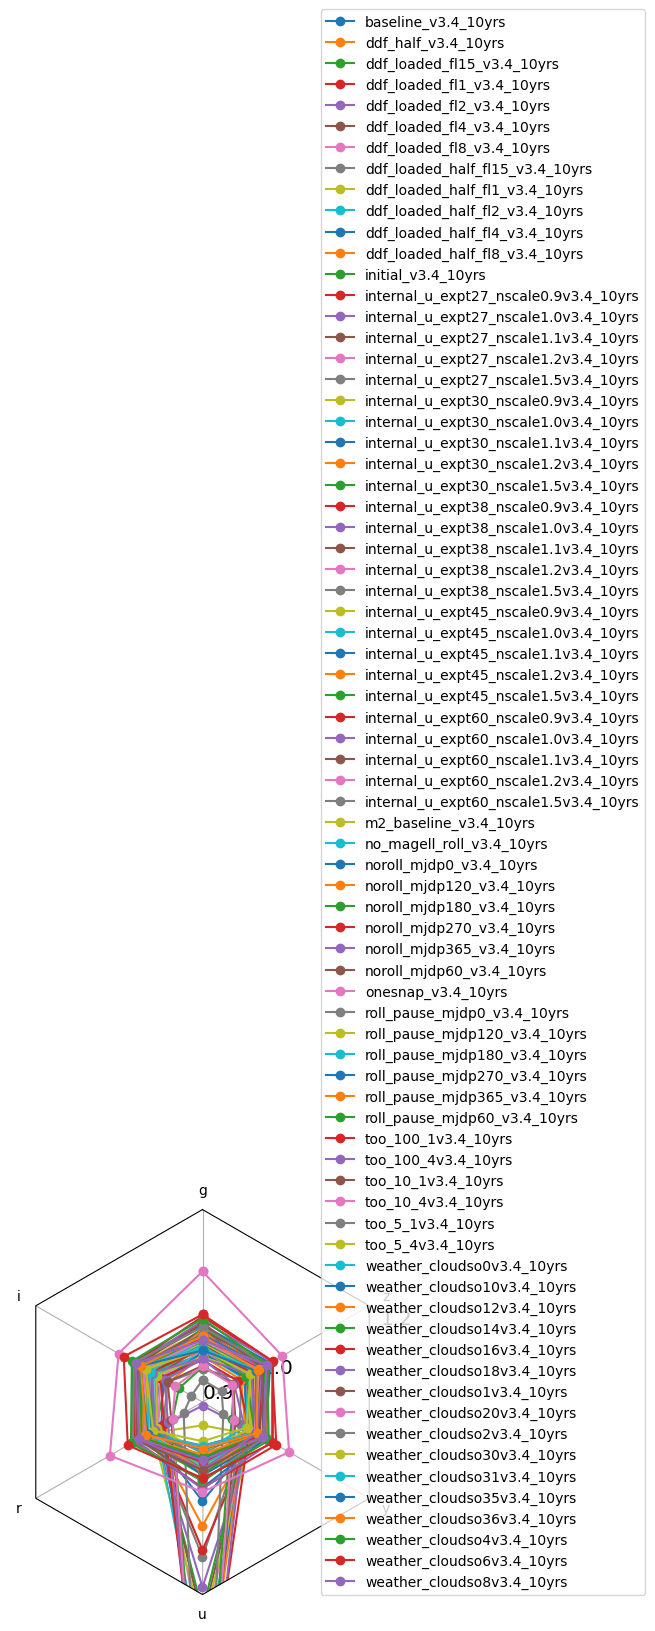

In [13]:
runs = [ run for run in data.index if '3.4' in run]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='initial_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

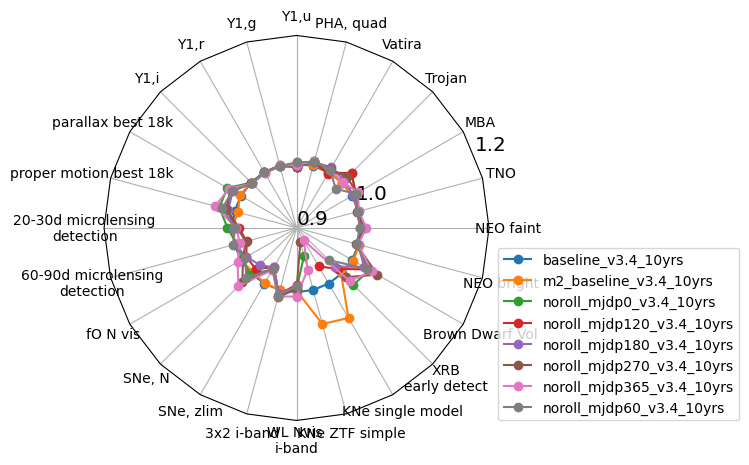

In [14]:
runs = [run for run in data.index if 'baseline_v3.4' in run or 'noroll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

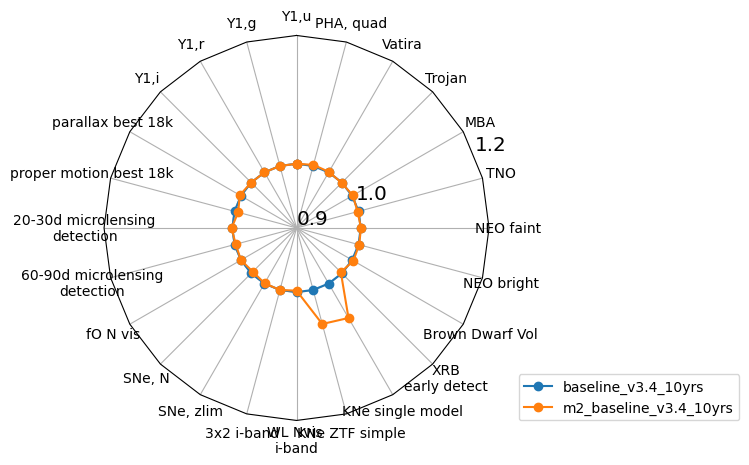

In [15]:
# Look at difference between cluster and Apple chips
runs = ['baseline_v3.4_10yrs', 'm2_baseline_v3.4_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

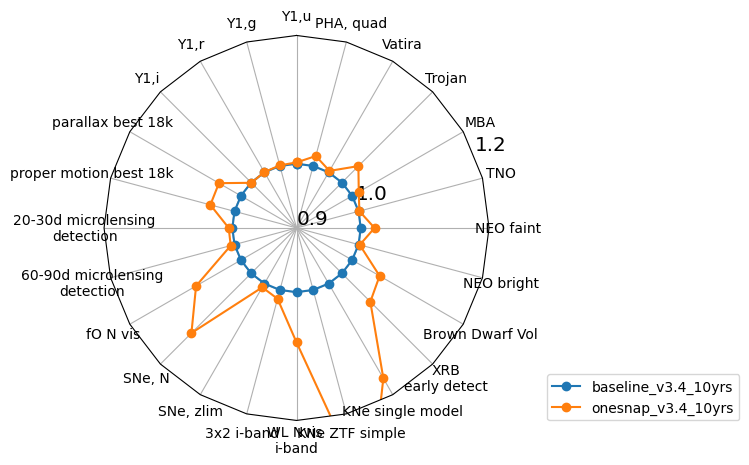

In [16]:
# One snap
runs = ['baseline_v3.4_10yrs', 'onesnap_v3.4_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

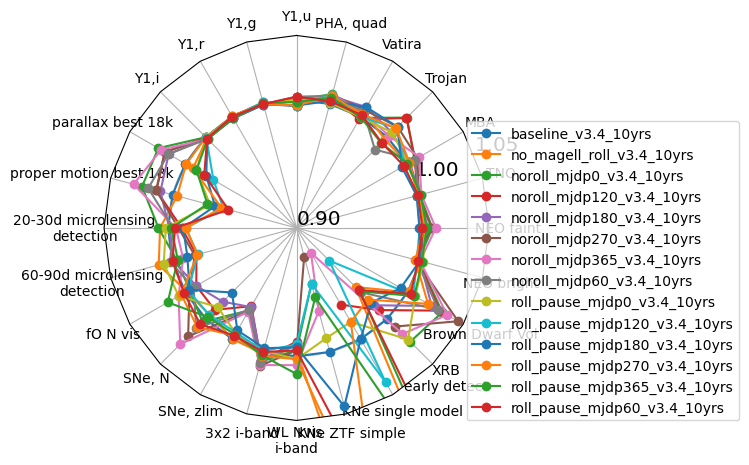

In [17]:
# various rolling
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'roll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [18]:


times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



Y1,u      Y1,g      Y1,r      Y1,i  \
retro_baseline_v2.0_10yrs  0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs        0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs        0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs        0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs        0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs        0.973633  0.982335  0.996170  0.995800   
baseline_v3.3_10yrs        0.987305  0.992712  0.997529  0.996294   
baseline_v3.4_10yrs        0.982282  0.991723  0.997529  0.999135   

                           parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs           0.804328                0.176701   
baseline_v2.0_10yrs                 0.791058                0.184088   
baseline_v2.1_10yrs                 0.806910                0.188258   
baseline_v2.2_10yrs                 0.792958                0.186345   
baseline_v3.0_10yrs                 0.792666                0.185683   
baseline_v3.2_10yrs                 0.782518                0.185369   
baseline_v3.3_10yrs                 0.753823                0.179042   
baseline_v3.4_10yrs                 0.753552                0.177359   

                           20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                          0.0878   
baseline_v2.0_10yrs                                0.3119   
baseline_v2.1_10yrs                                0.3141   
baseline_v2.2_10yrs                                0.3268   
baseline_v3.0_10yrs                                0.3232   
baseline_v3.2_10yrs                                0.3437   
baseline_v3.3_10yrs                                0.3817   
baseline_v3.4_10yrs                                0.3744   

                           60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                          0.1568     848.0   
baseline_v2.0_10yrs                                0.4348     839.0   
baseline_v2.1_10yrs                                0.4319     838.0   
baseline_v2.2_10yrs                                0.4487     830.0   
baseline_v3.0_10yrs                                0.4528     795.0   
baseline_v3.2_10yrs                                0.4869     805.0   
baseline_v3.3_10yrs                                0.5233     811.0   
baseline_v3.4_10yrs                                0.5227     817.0   

                                  SNe, N  ...  KNe single model  \
retro_baseline_v2.0_10yrs   97124.012102  ...              89.0   
baseline_v2.0_10yrs         99302.532220  ...             108.0   
baseline_v2.1_10yrs         99294.339899  ...              82.0   
baseline_v2.2_10yrs        112802.099640  ...             106.0   
baseline_v3.0_10yrs        109475.798536  ...             118.0   
baseline_v3.2_10yrs        123176.659086  ...             112.0   
baseline_v3.3_10yrs        152910.228661  ...             122.0   
baseline_v3.4_10yrs        150561.591416  ...             129.0   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs              724.0    179640.718155      0.9048   
baseline_v2.0_10yrs                   1868.0    168086.074111      0.9294   
baseline_v2.1_10yrs                   1885.0    163815.013503      0.9286   
baseline_v2.2_10yrs                   1919.0    172453.127988      0.9304   
baseline_v3.0_10yrs                   1924.0    168032.537231      0.9326   
baseline_v3.2_10yrs                   2032.0    174053.517478      0.9460   
baseline_v3.3_10yrs                   2080.0    188222.084374      0.9442   
baseline_v3.4_10yrs                   2091.0    189004.878306      0.9480   

                           NEO faint       TNO       MBA    Trojan  Vatira  \
retro_baseline_v2.0_10yrs   0.624144  0.705922  0.943673  0.667514  0.0000   
baseline_v2.0_10yrs         0.642165  0.719712  0.919119  0.588234  0.0039   
baseline_v2.1_10yrs         0.647818  

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_13020/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


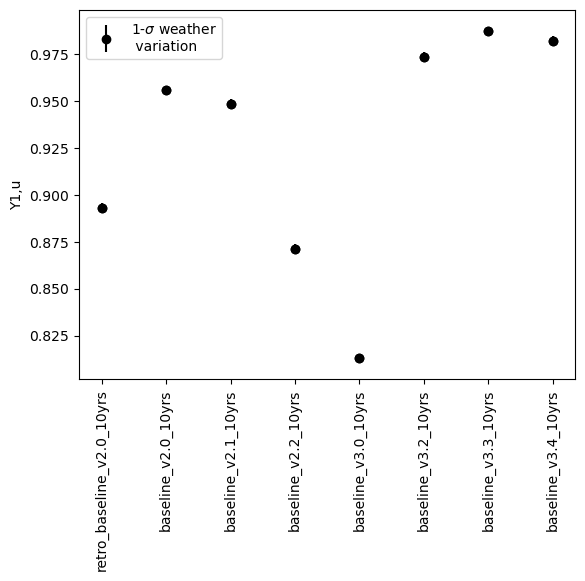

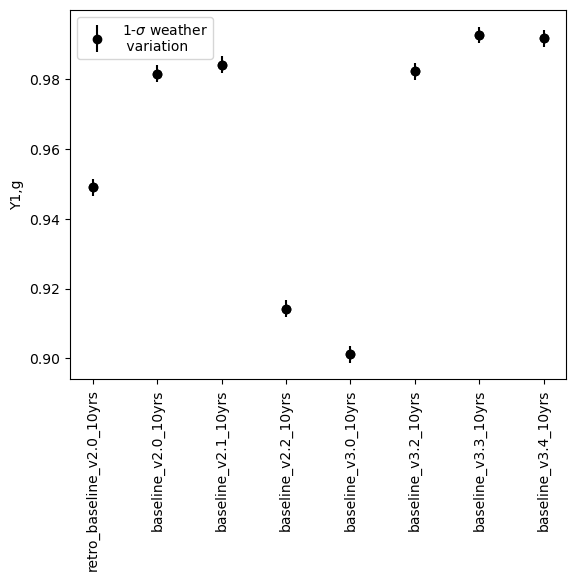

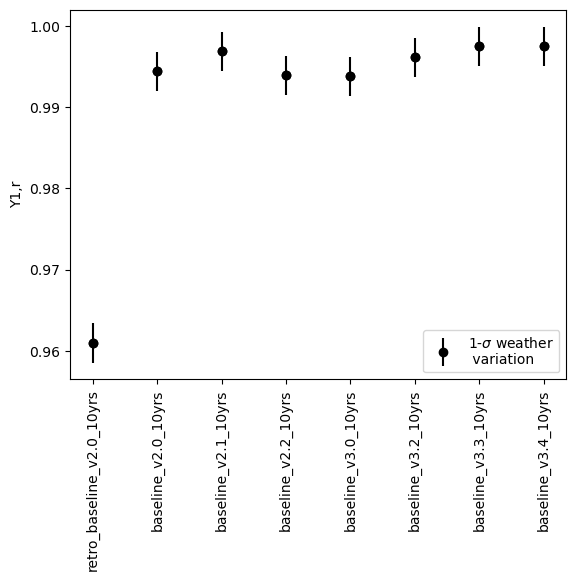

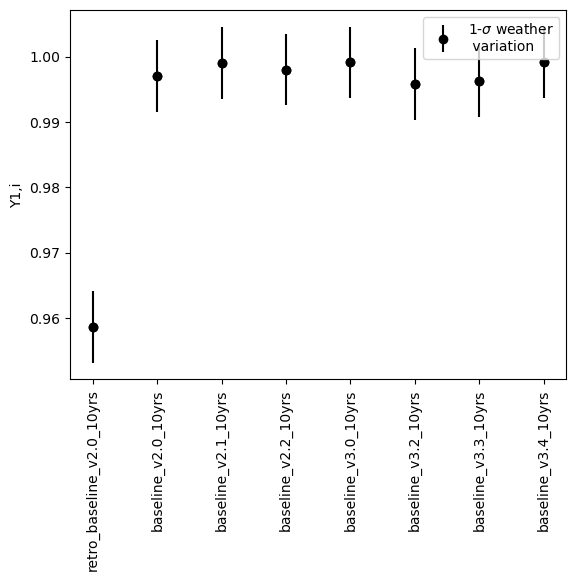

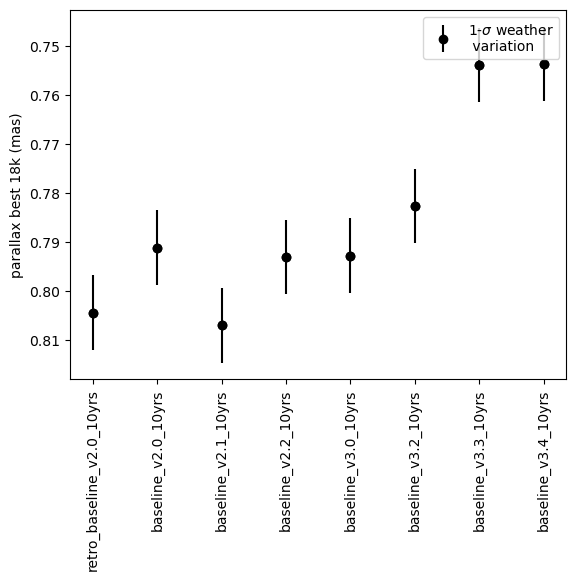

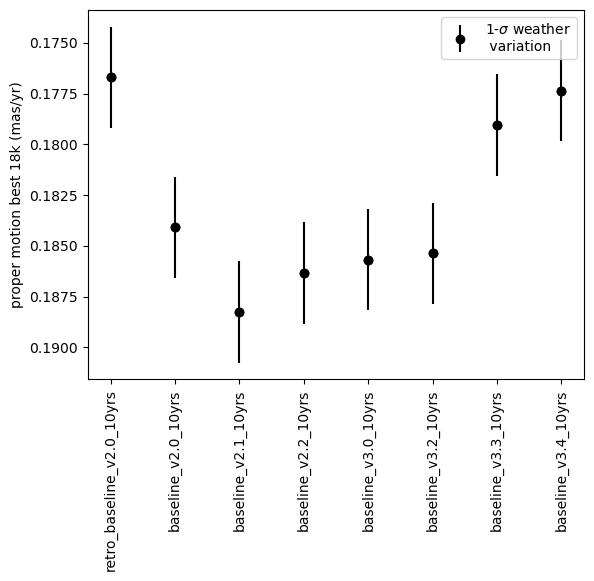

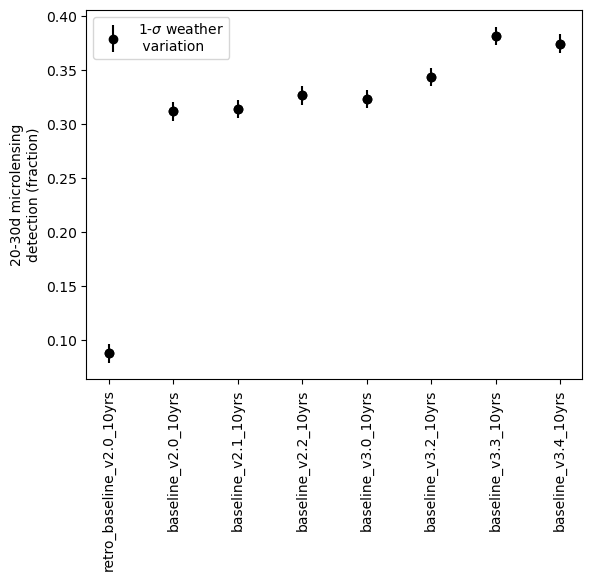

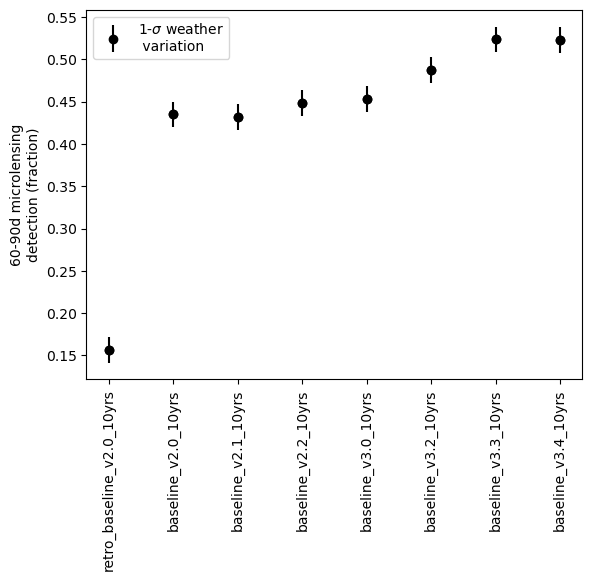

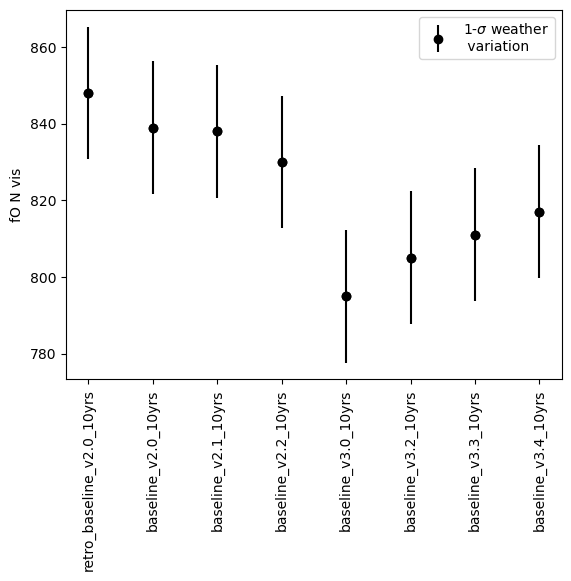

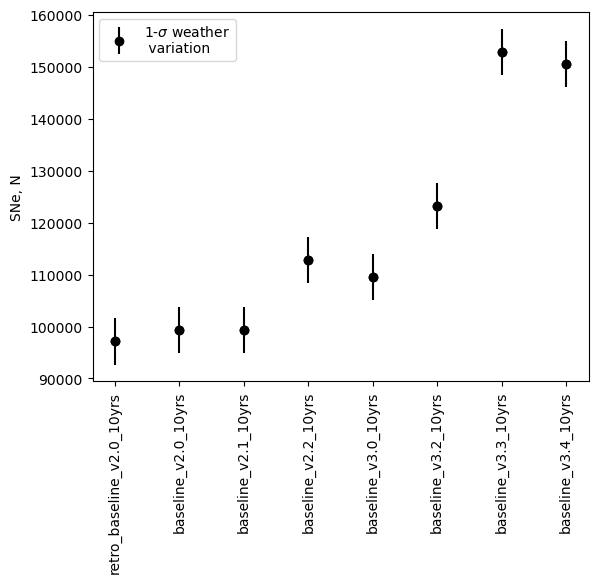

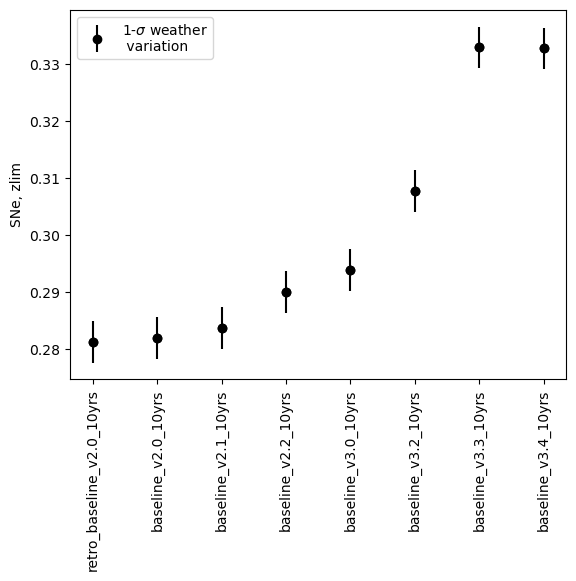

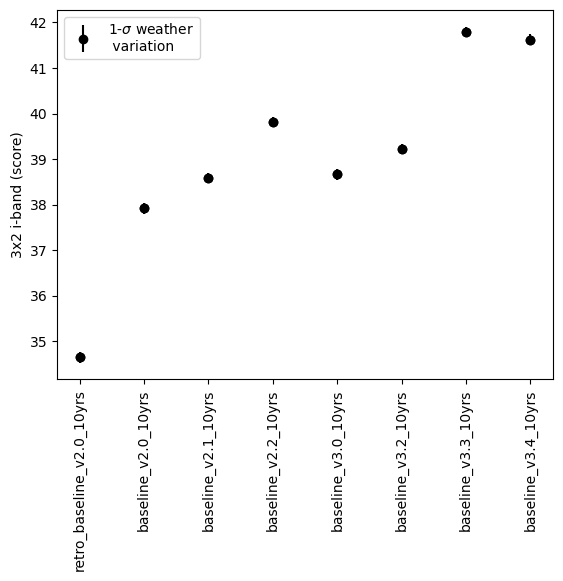

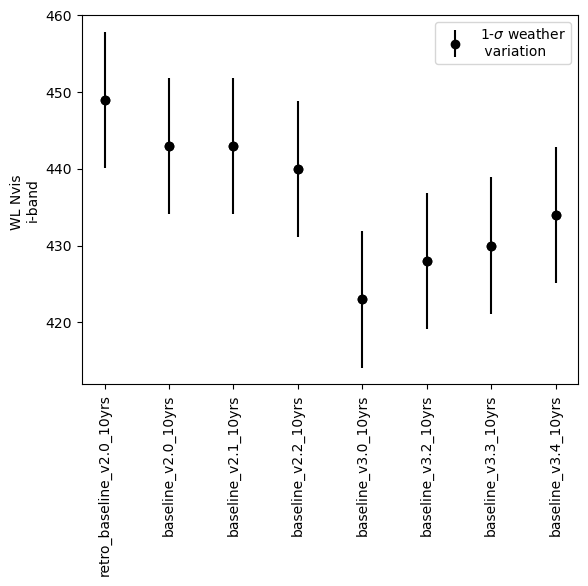

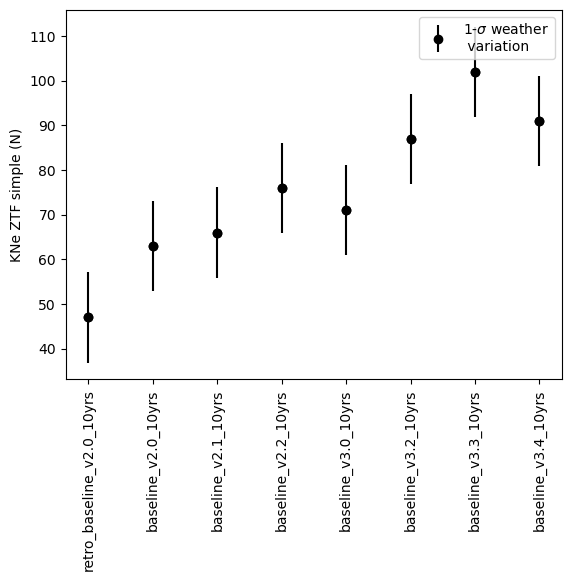

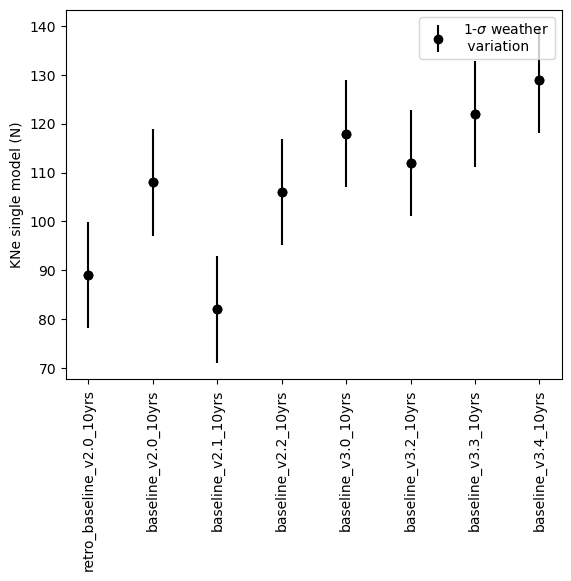

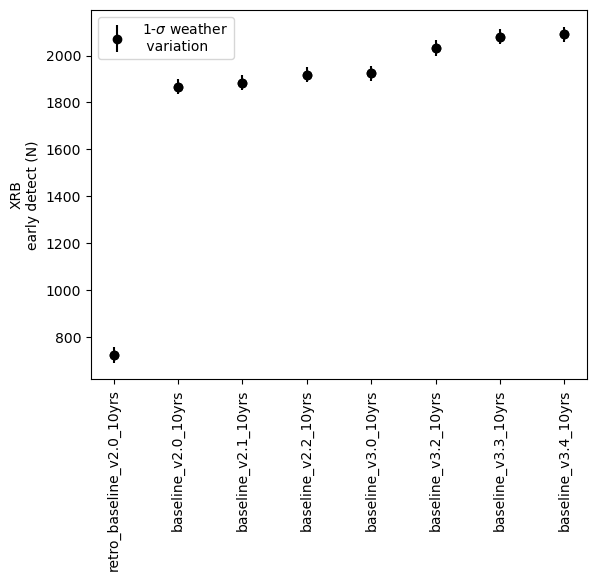

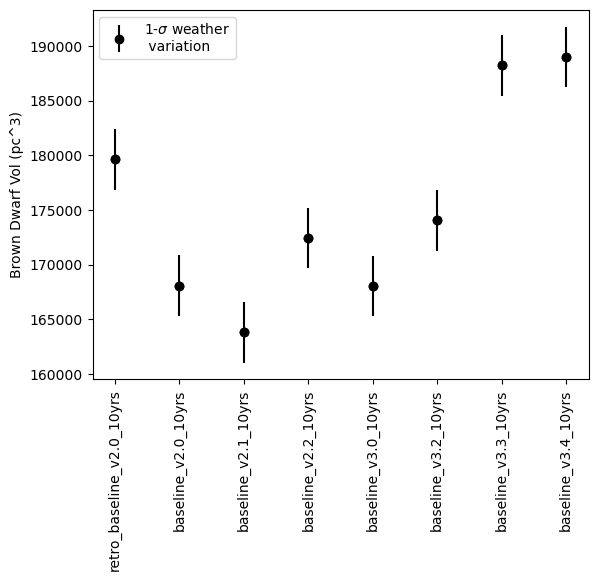

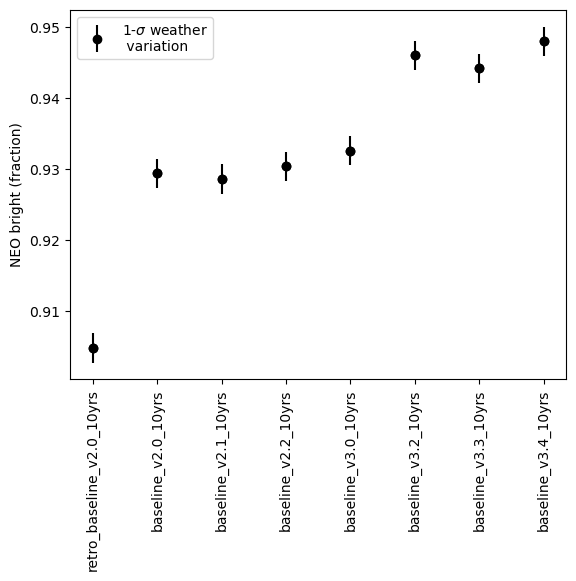

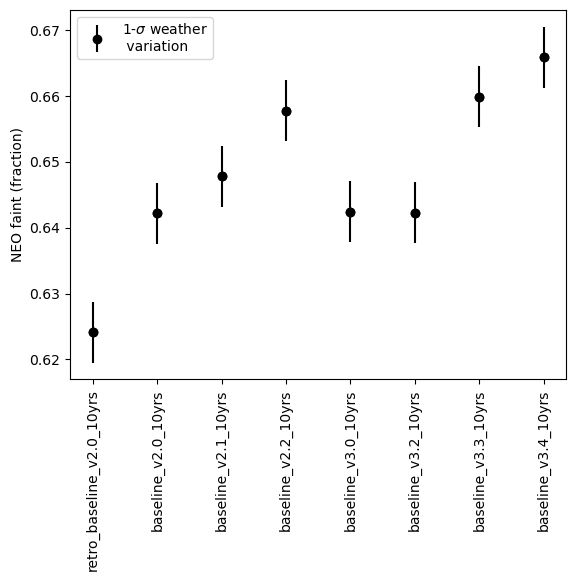

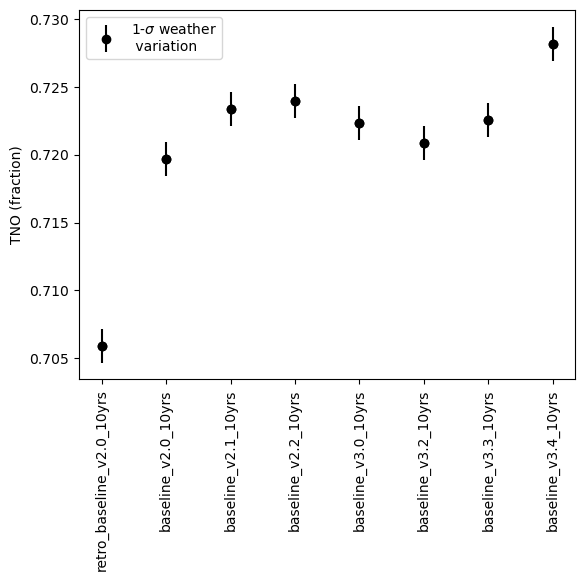

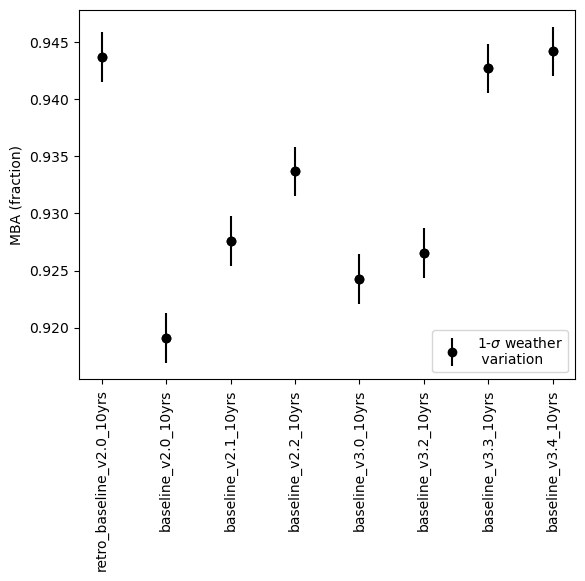

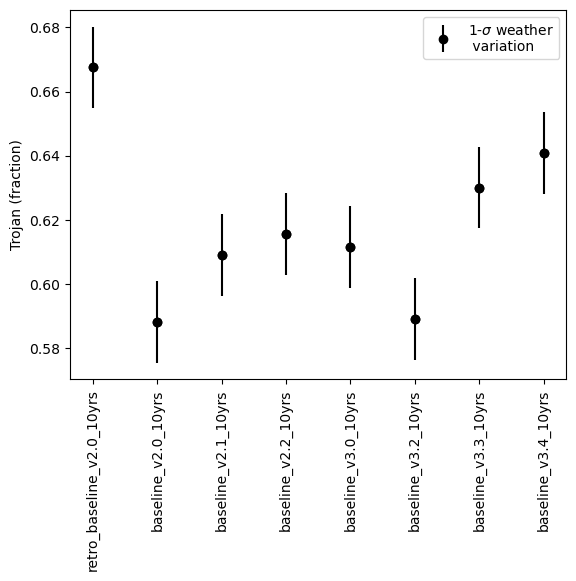

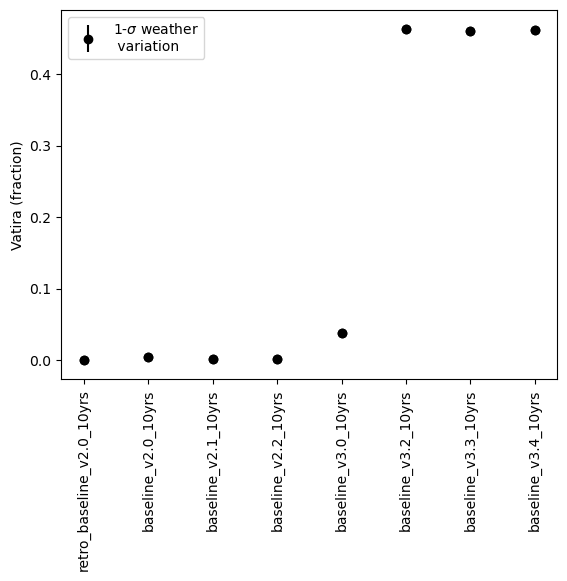

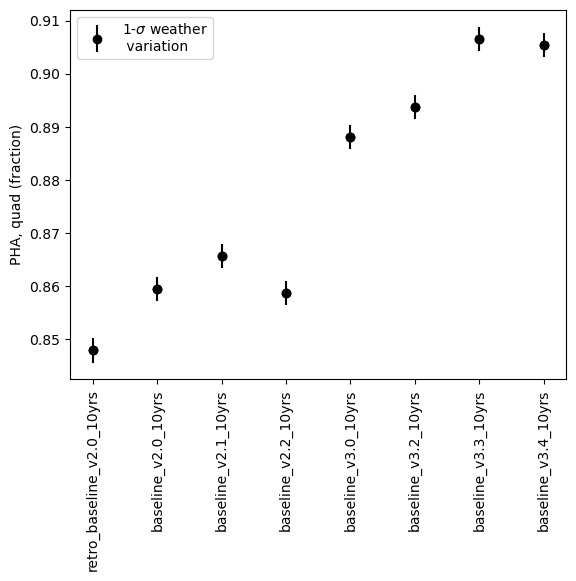

In [19]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_13020/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


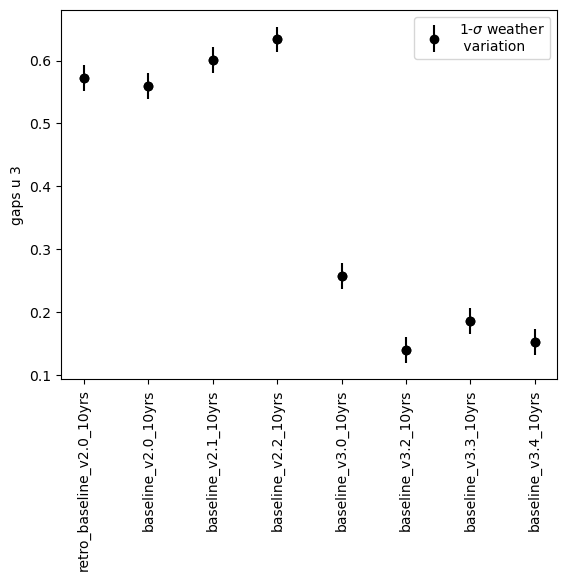

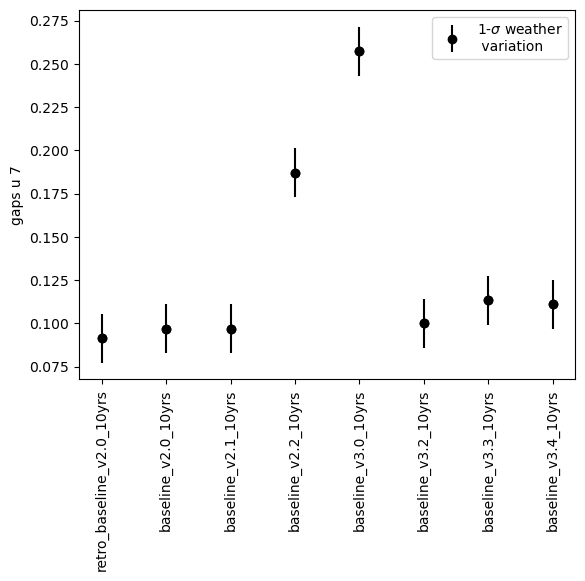

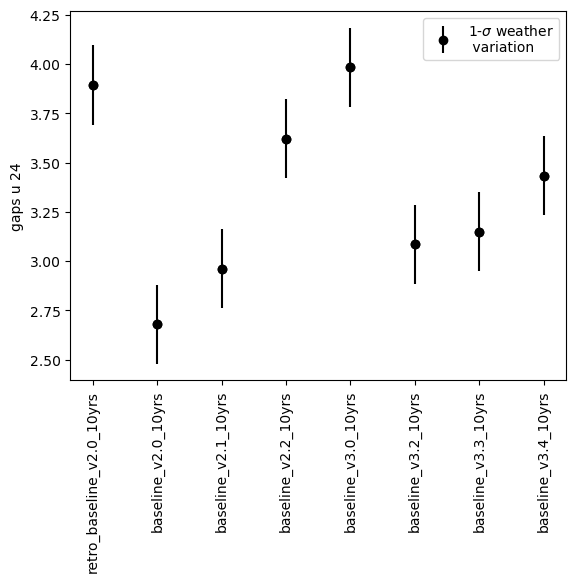

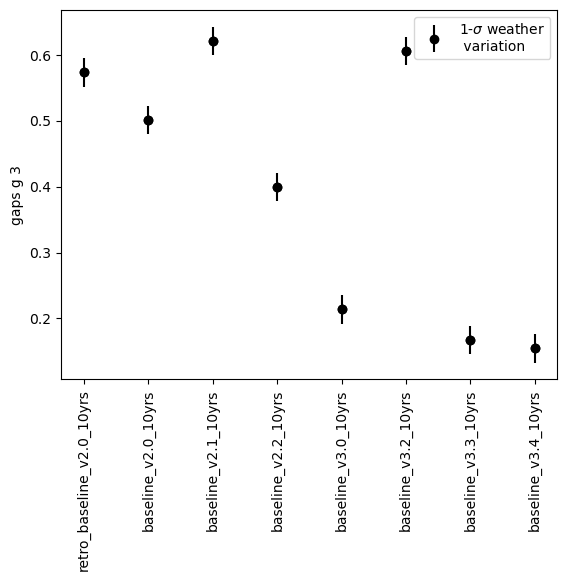

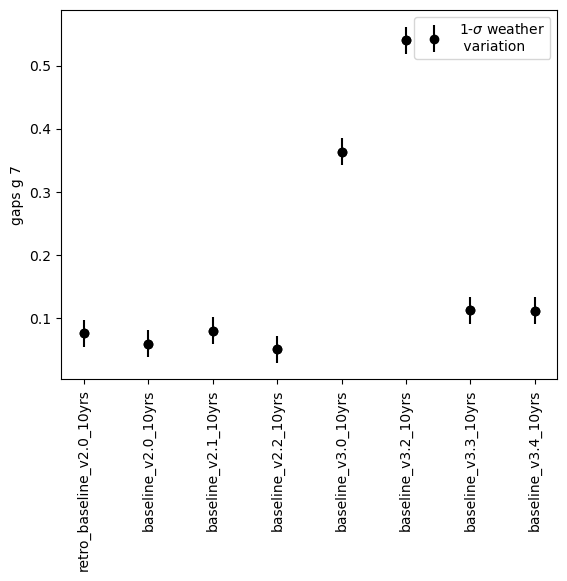

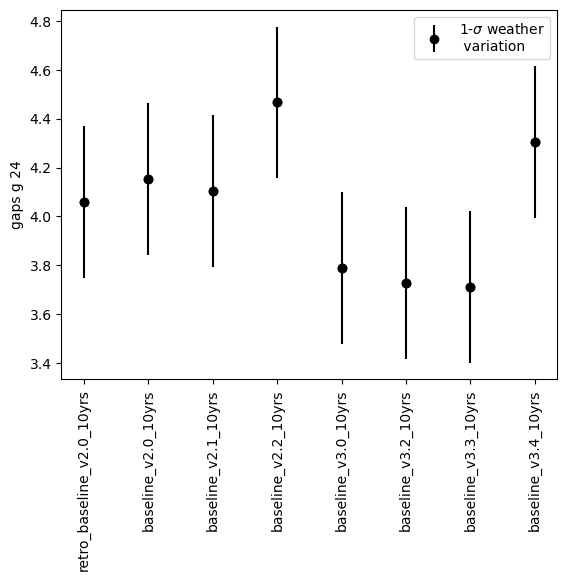

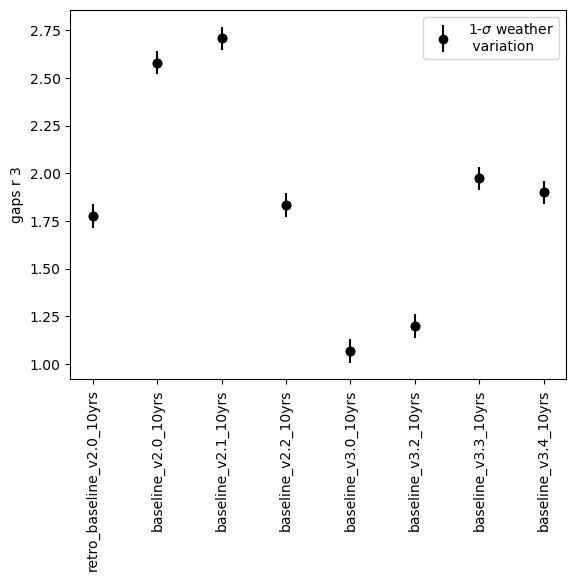

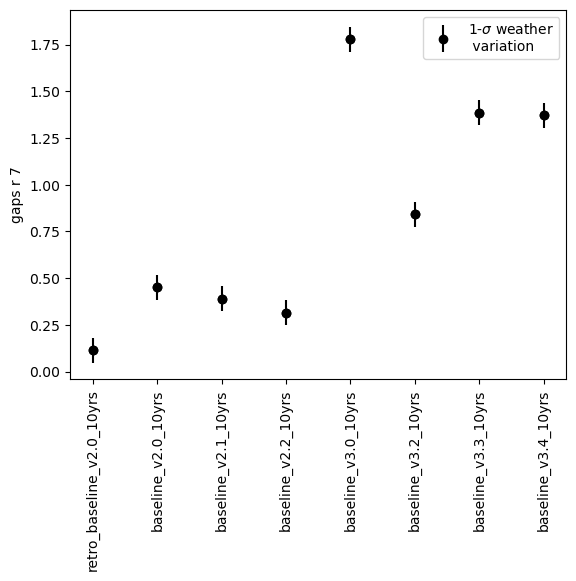

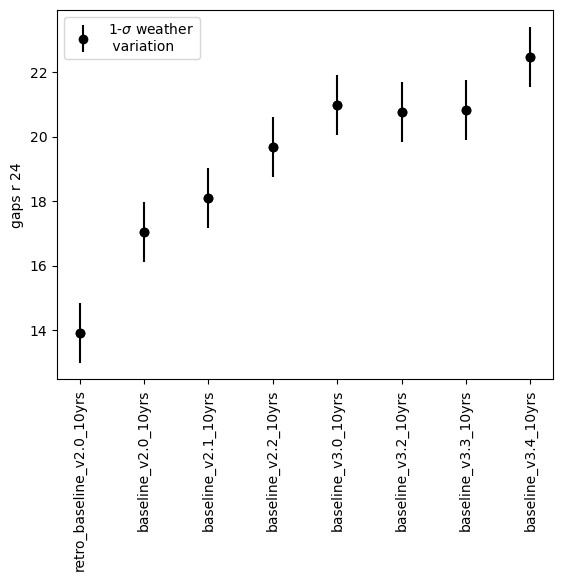

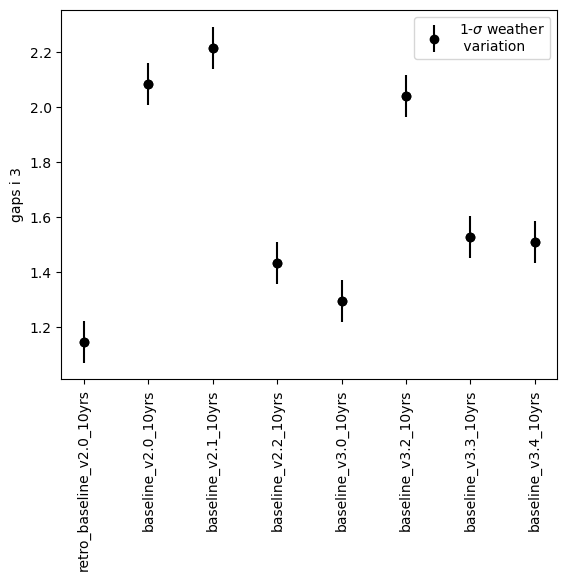

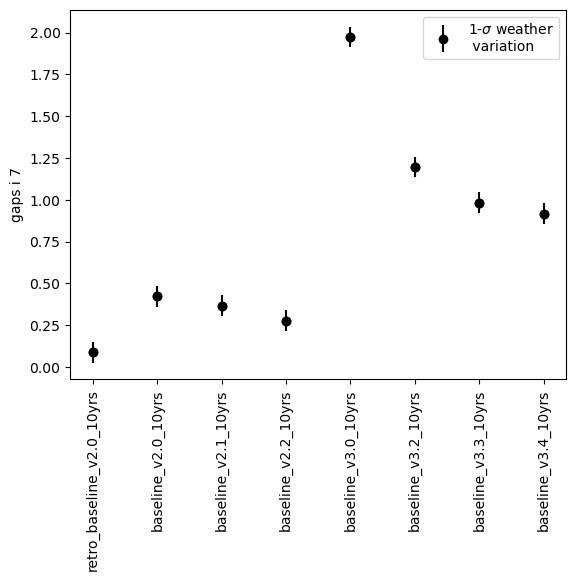

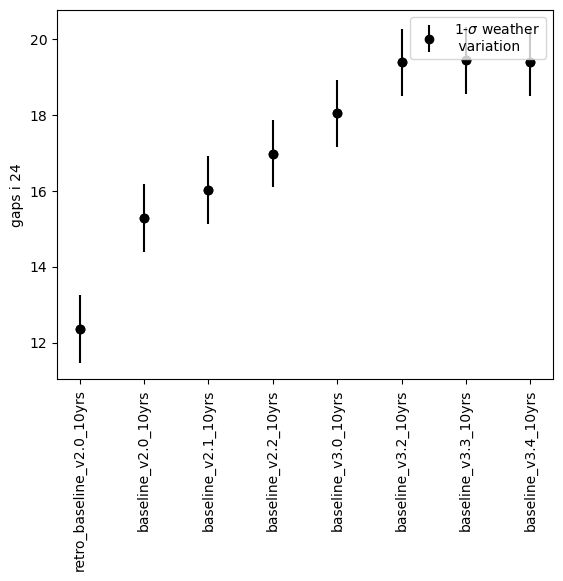

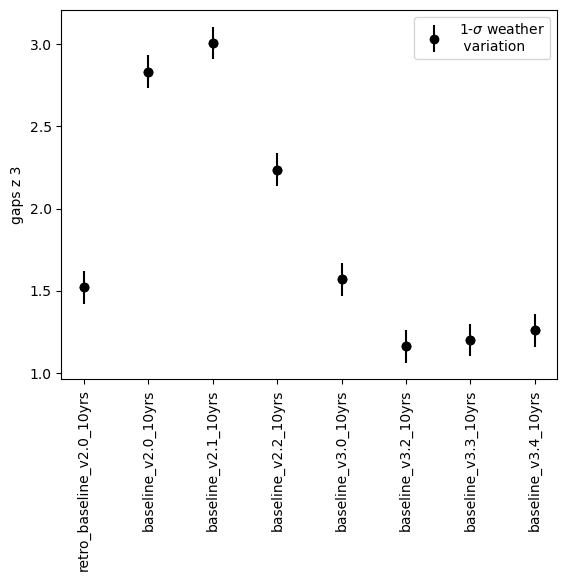

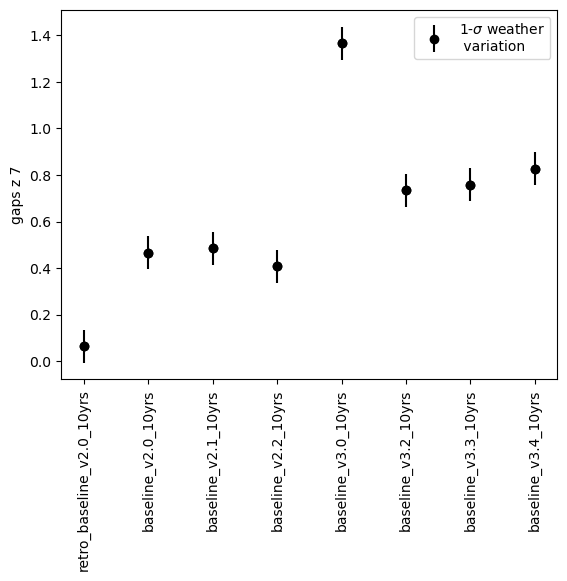

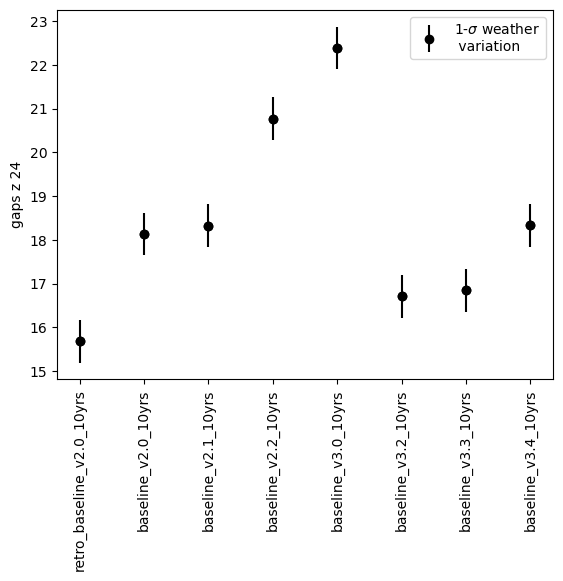

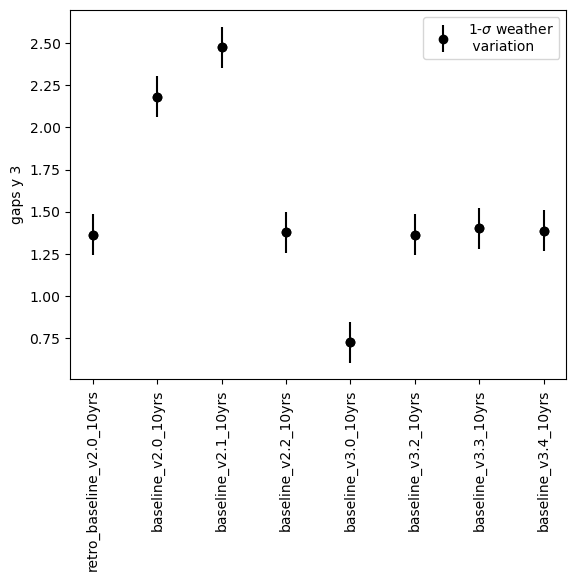

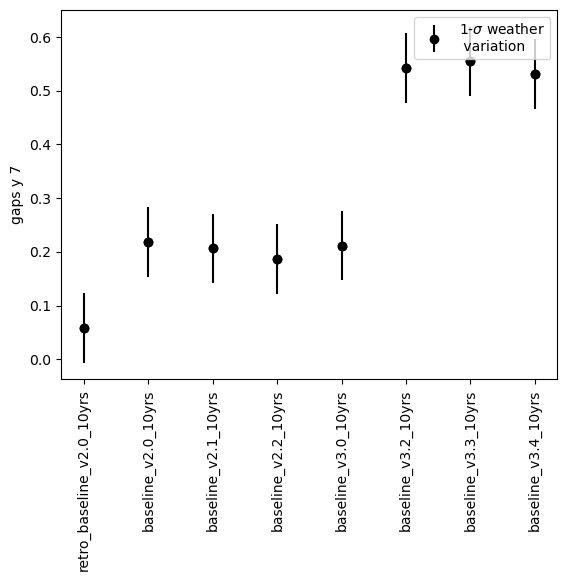

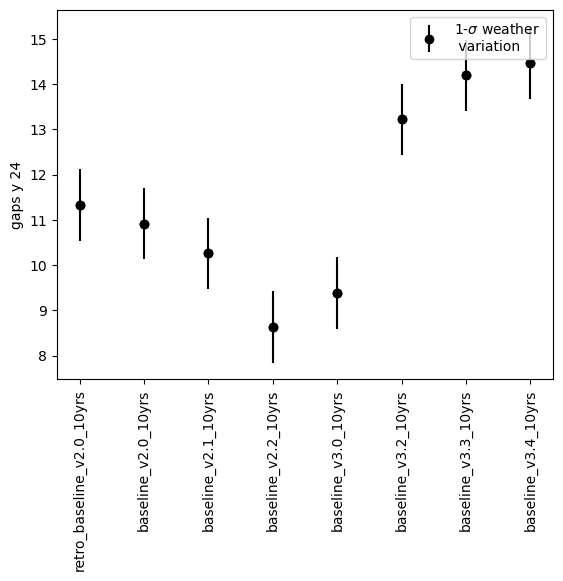

In [20]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_13020/3981456560.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


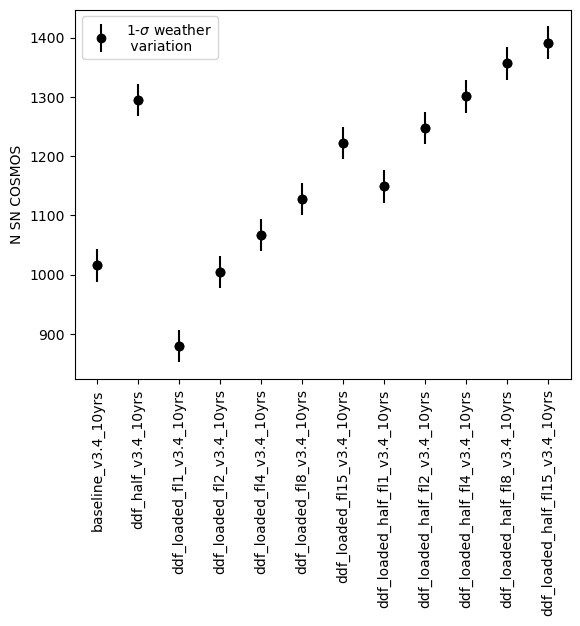

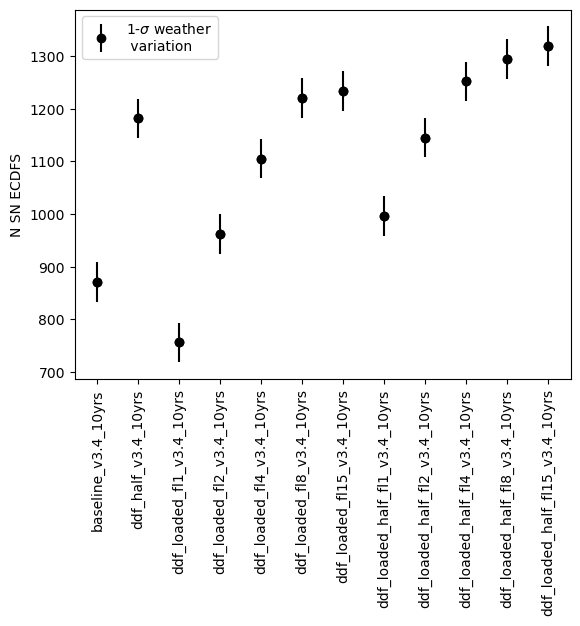

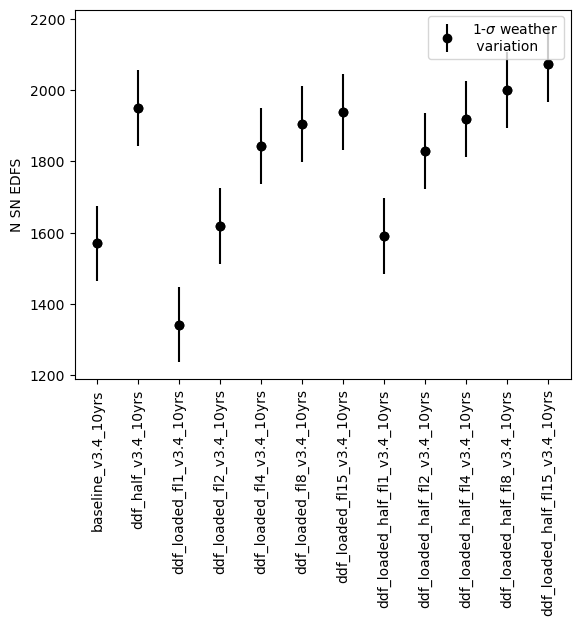

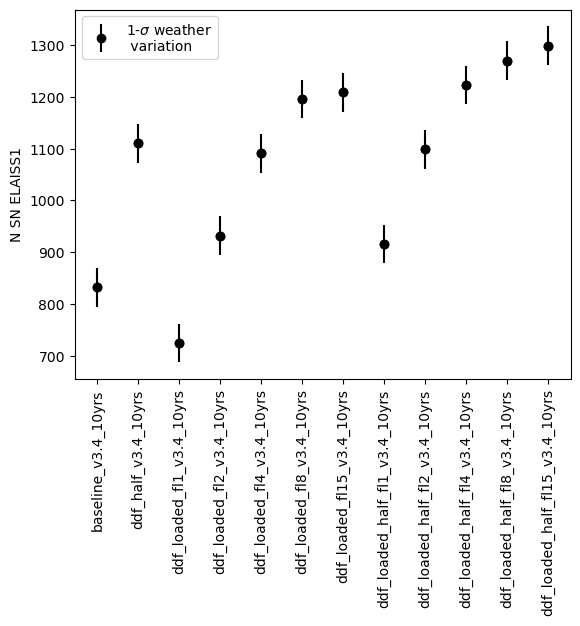

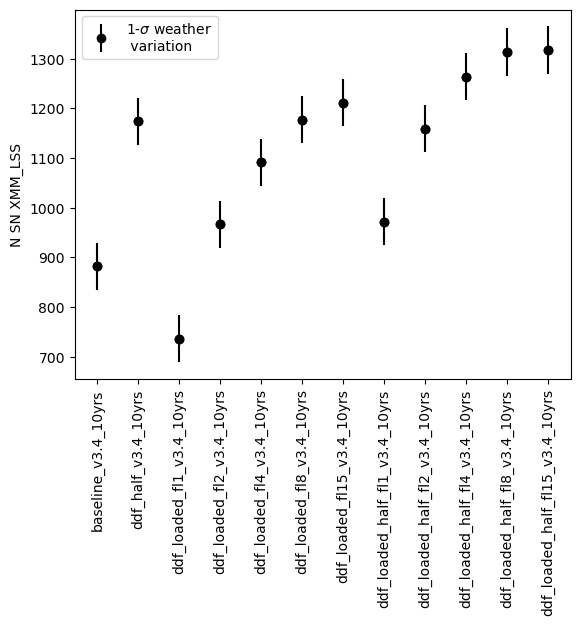

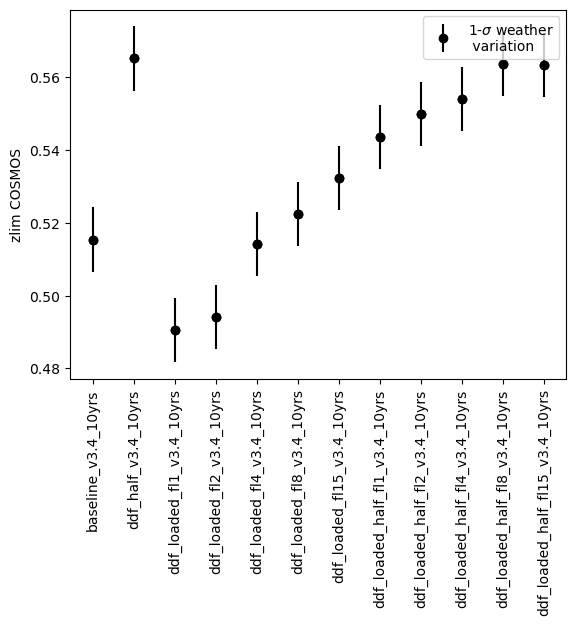

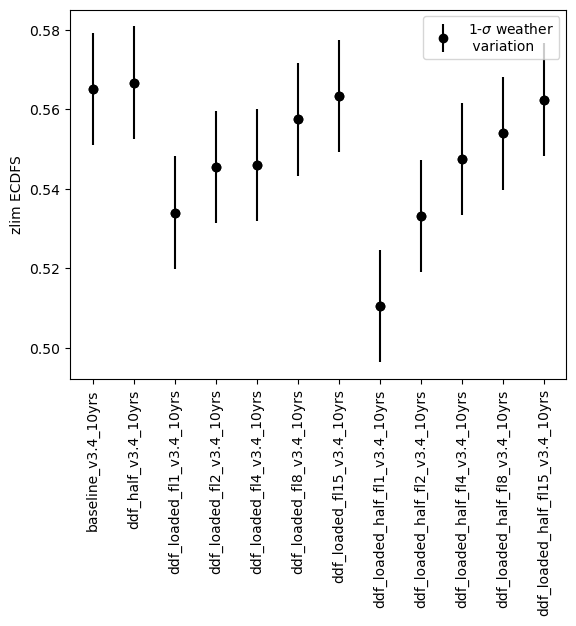

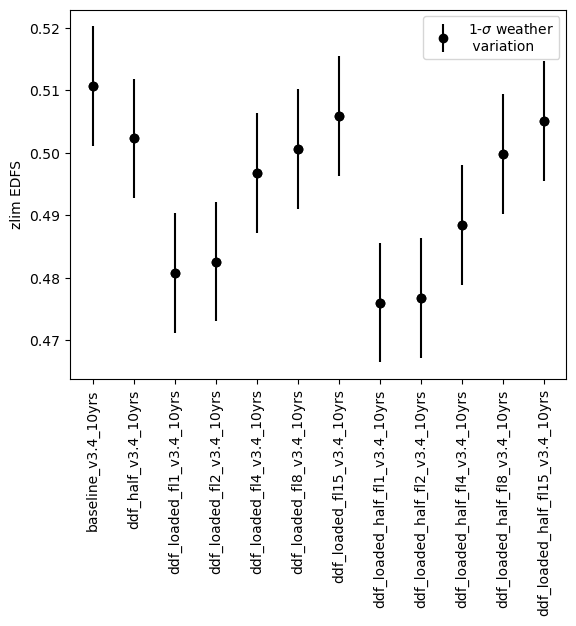

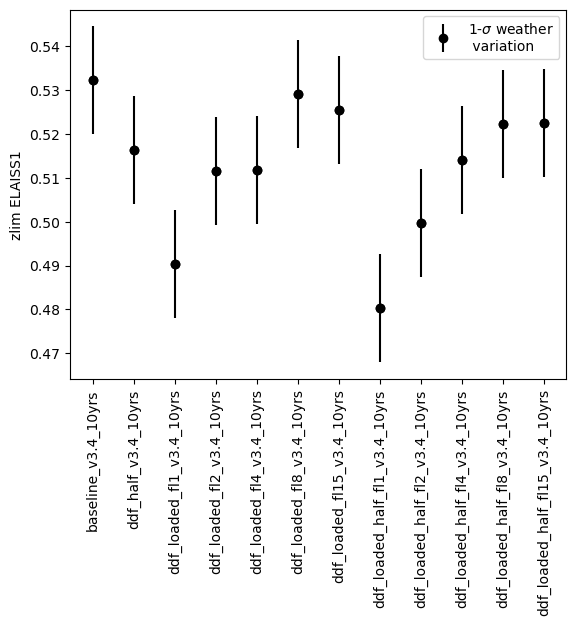

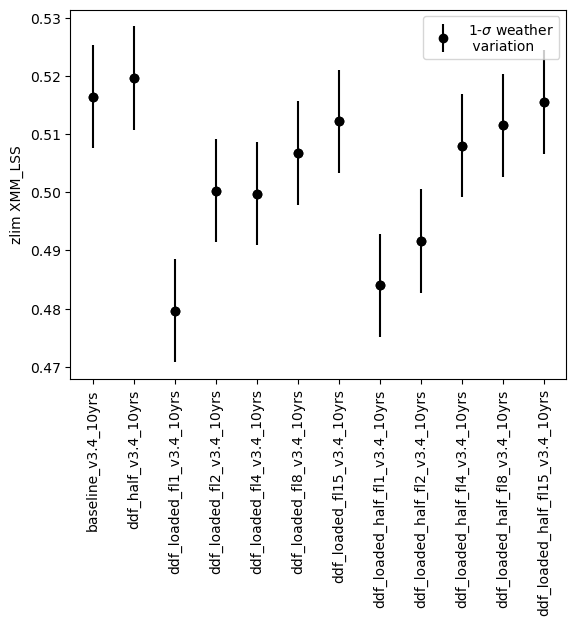

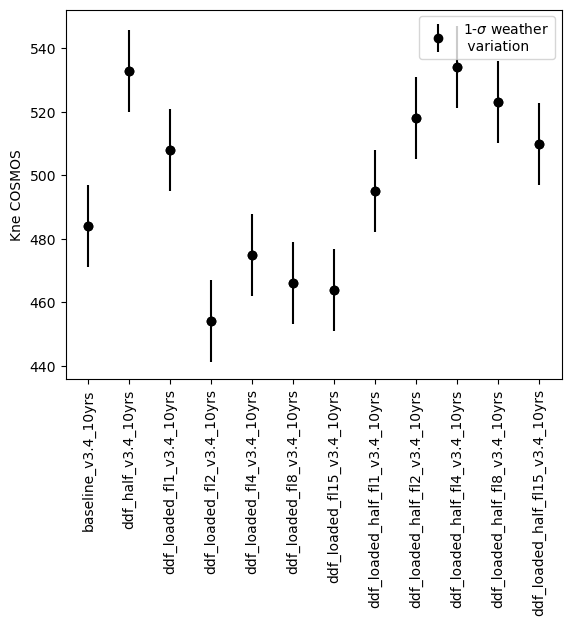

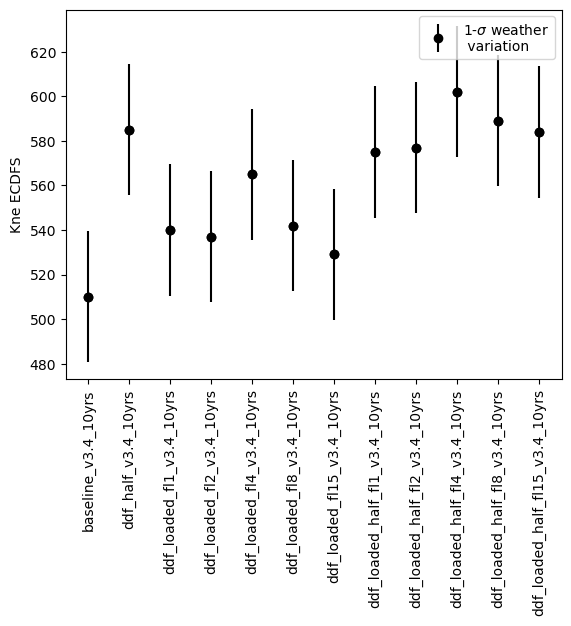

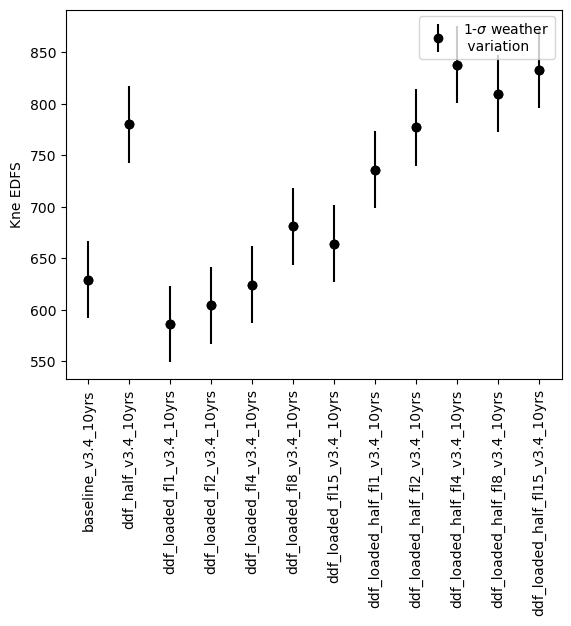

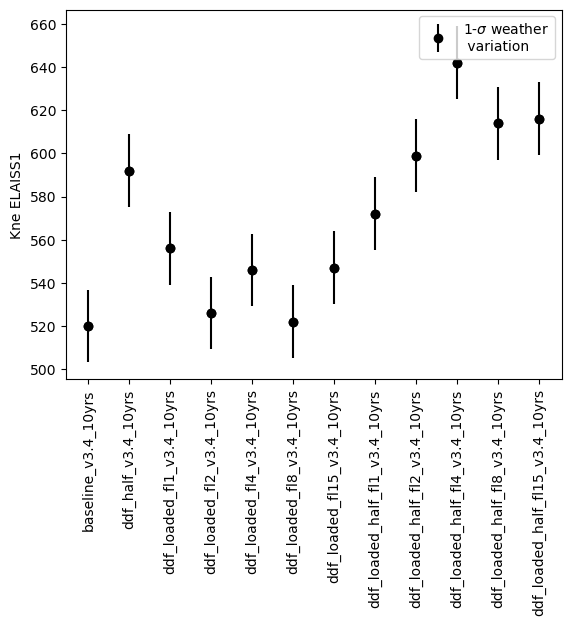

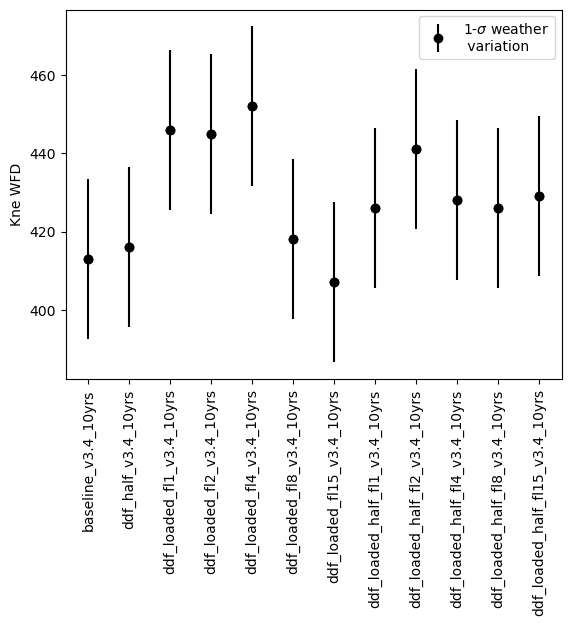

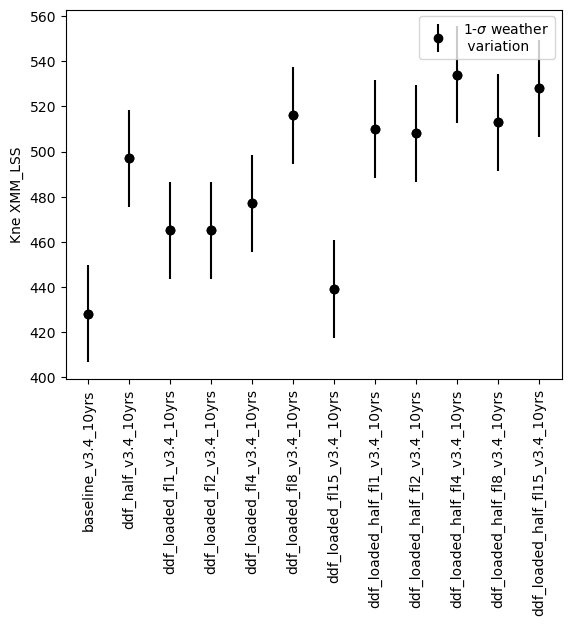

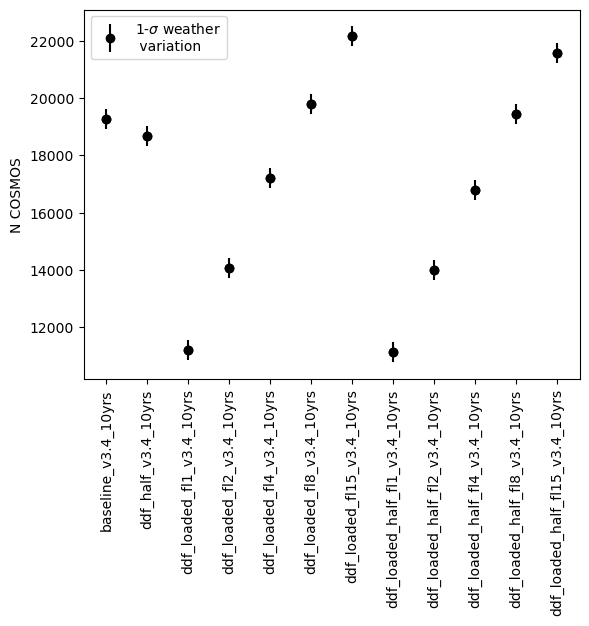

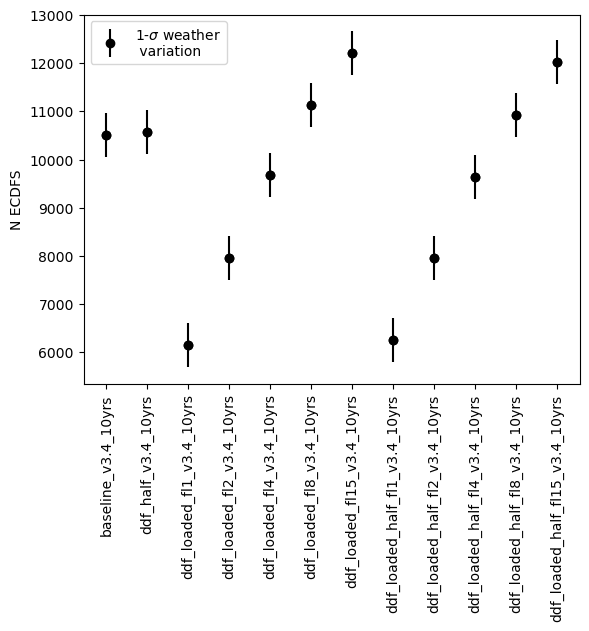

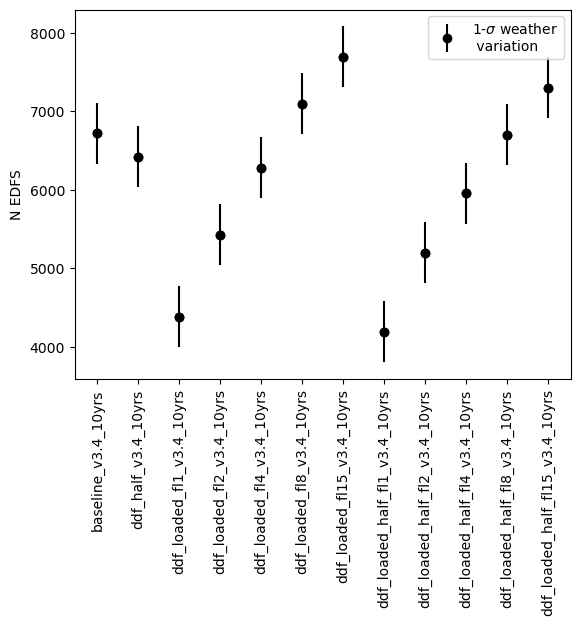

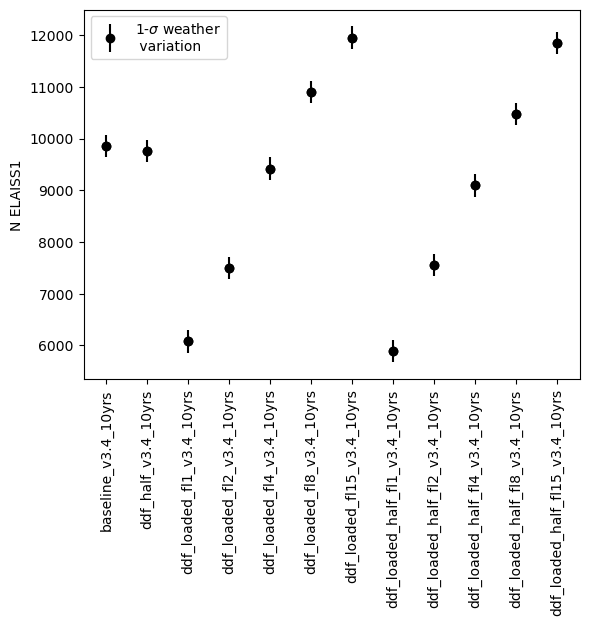

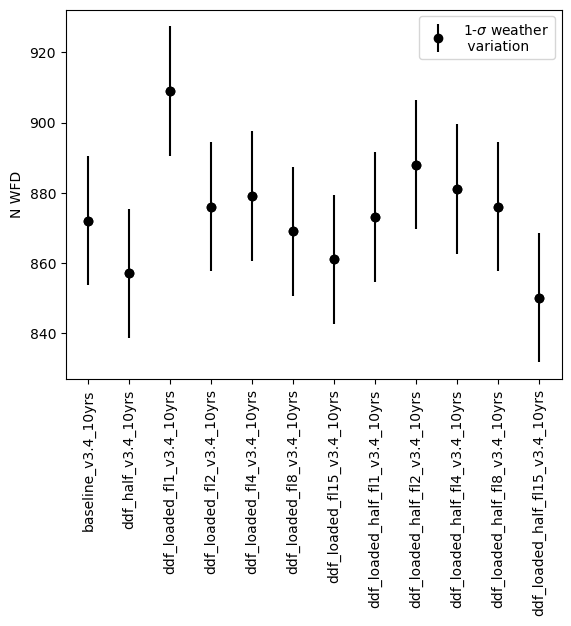

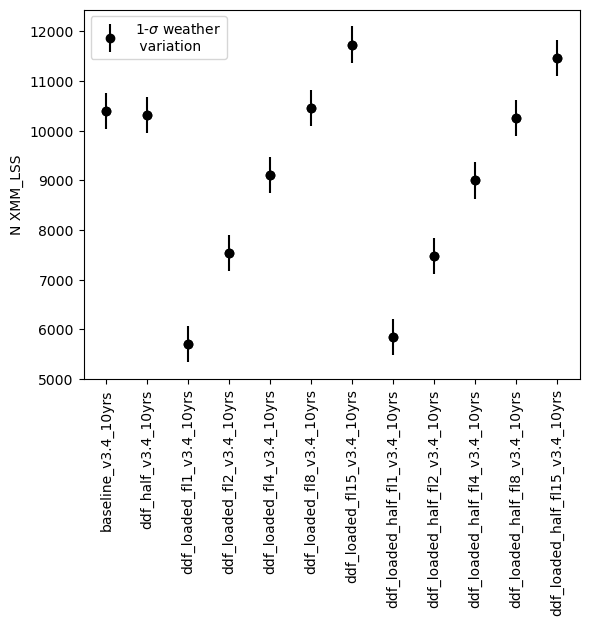

In [42]:
#times = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]
times = ['baseline_v3.4_10yrs',
 'ddf_half_v3.4_10yrs',
 
 'ddf_loaded_fl1_v3.4_10yrs',
 'ddf_loaded_fl2_v3.4_10yrs',
 'ddf_loaded_fl4_v3.4_10yrs',
 'ddf_loaded_fl8_v3.4_10yrs',
 'ddf_loaded_fl15_v3.4_10yrs',
 'ddf_loaded_half_fl1_v3.4_10yrs',
 'ddf_loaded_half_fl2_v3.4_10yrs',
 'ddf_loaded_half_fl4_v3.4_10yrs',
 'ddf_loaded_half_fl8_v3.4_10yrs',
        'ddf_loaded_half_fl15_v3.4_10yrs',]
sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

['baseline_v3.4_10yrs',
 'ddf_half_v3.4_10yrs',
 'ddf_loaded_fl15_v3.4_10yrs',
 'ddf_loaded_fl1_v3.4_10yrs',
 'ddf_loaded_fl2_v3.4_10yrs',
 'ddf_loaded_fl4_v3.4_10yrs',
 'ddf_loaded_fl8_v3.4_10yrs',
 'ddf_loaded_half_fl15_v3.4_10yrs',
 'ddf_loaded_half_fl1_v3.4_10yrs',
 'ddf_loaded_half_fl2_v3.4_10yrs',
 'ddf_loaded_half_fl4_v3.4_10yrs',
 'ddf_loaded_half_fl8_v3.4_10yrs']

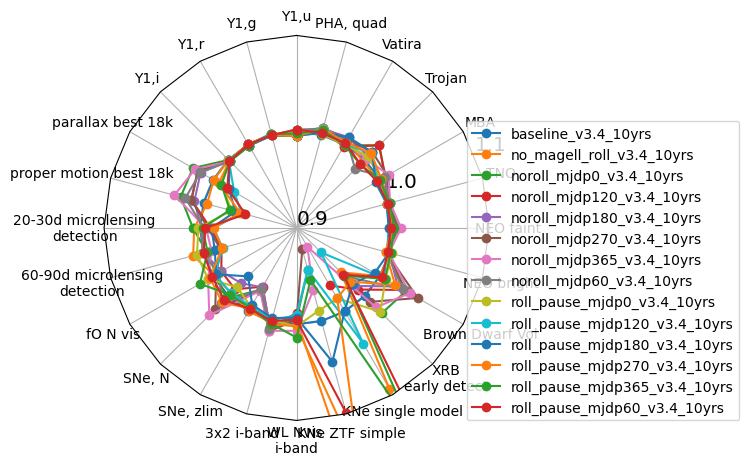

In [22]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'roll' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

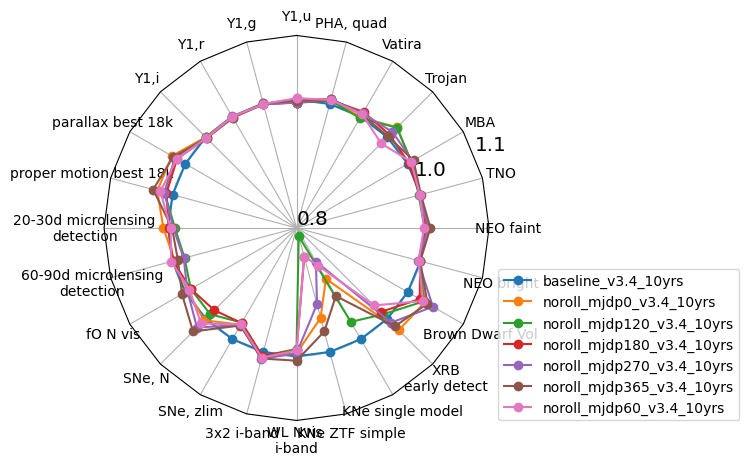

In [23]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'noroll' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

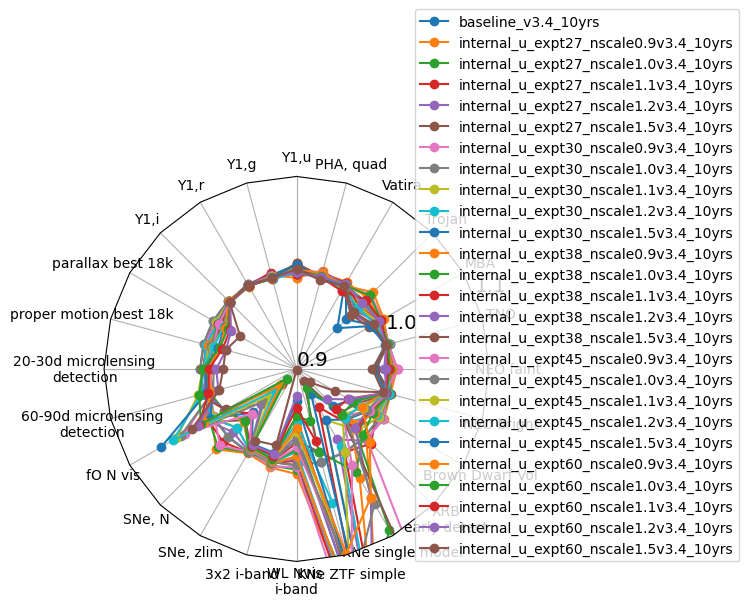

In [24]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

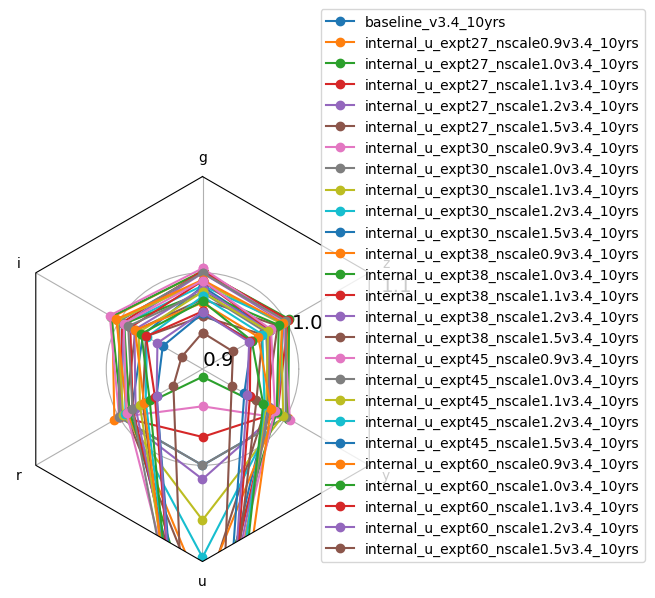

In [25]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

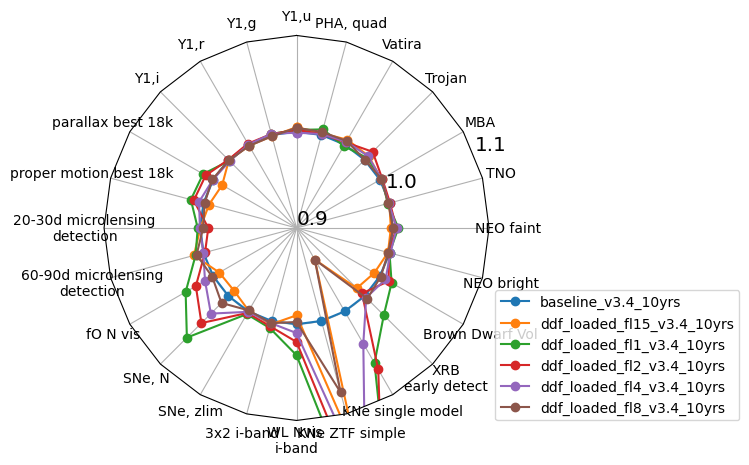

In [26]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

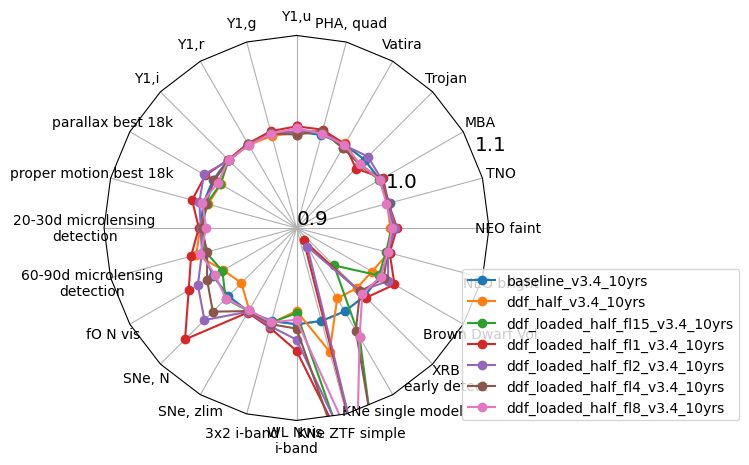

In [27]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

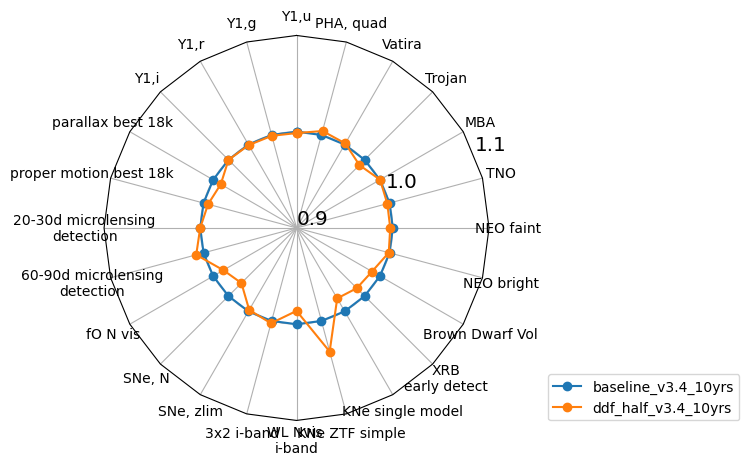

In [28]:
runs = ['baseline_v3.4_10yrs', 'ddf_half_v3.4_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

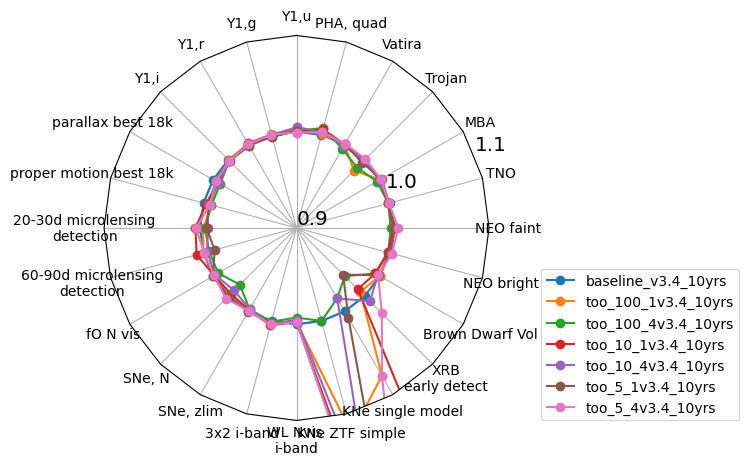

In [29]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

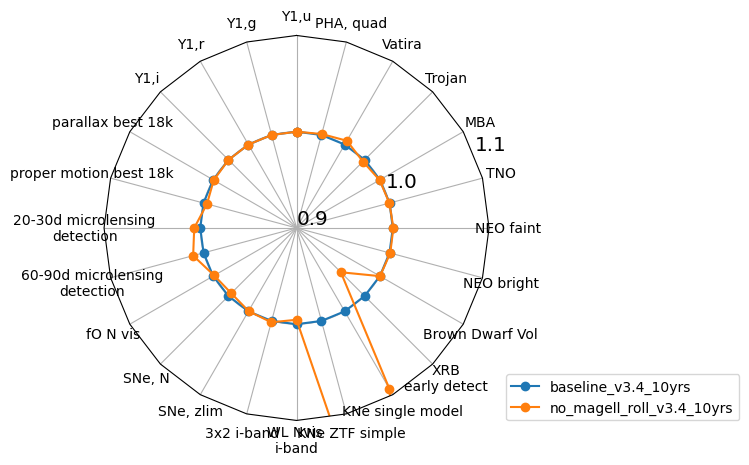

In [30]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'no_magel' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

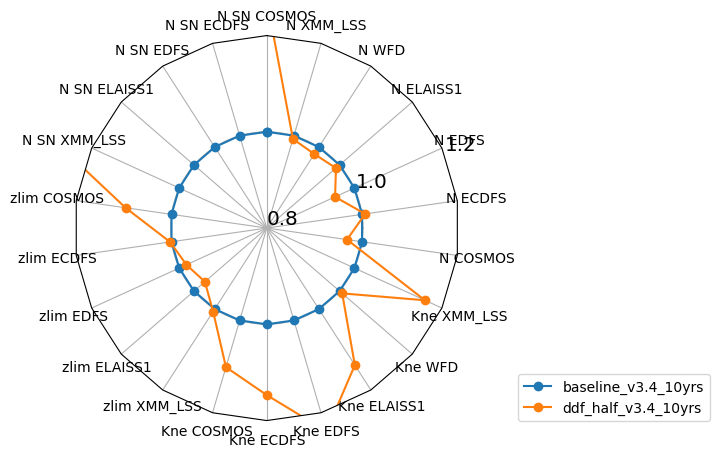

In [31]:
runs = ['baseline_v3.4_10yrs', 'ddf_half_v3.4_10yrs'] 

ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

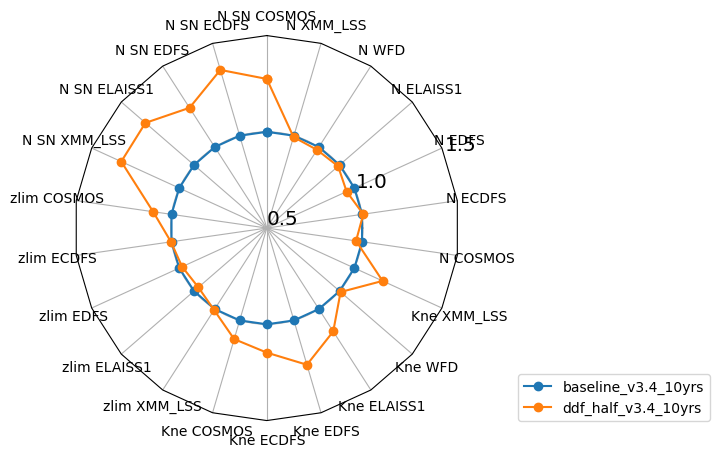

In [32]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

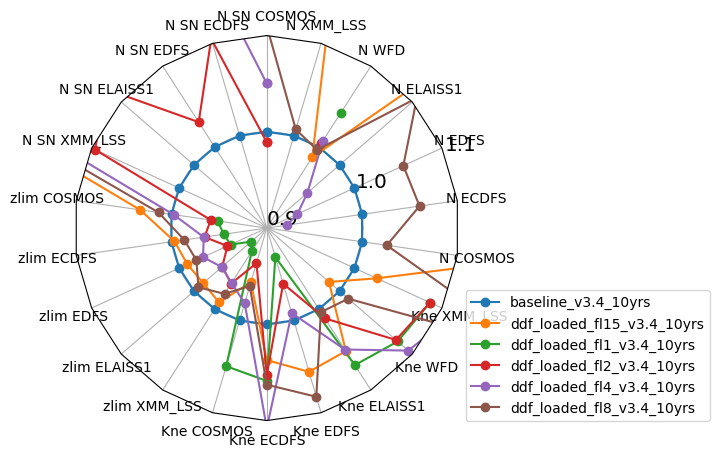

In [33]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [34]:
ndata

N SN COSMOS  N SN ECDFS  N SN EDFS  N SN ELAISS1  \
baseline_v3.4_10yrs            1.000000    1.000000   1.000000      1.000000   
ddf_loaded_fl15_v3.4_10yrs     1.203182    1.416313   1.235048      1.453176   
ddf_loaded_fl1_v3.4_10yrs      0.865797    0.868067   0.854832      0.870631   
ddf_loaded_fl2_v3.4_10yrs      0.989123    1.104937   1.030818      1.119923   
ddf_loaded_fl4_v3.4_10yrs      1.050191    1.268689   1.174053      1.311050   
ddf_loaded_fl8_v3.4_10yrs      1.109869    1.400550   1.213376      1.437191   

                            N SN XMM_LSS  zlim COSMOS  zlim ECDFS  zlim EDFS  \
baseline_v3.4_10yrs             1.000000     1.000000    1.000000   1.000000   
ddf_loaded_fl15_v3.4_10yrs      1.373822     1.032985    0.996896   0.990705   
ddf_loaded_fl1_v3.4_10yrs       0.834693     0.951693    0.945124   0.941330   
ddf_loaded_fl2_v3.4_10yrs       1.096288     0.958825    0.965368   0.944974   
ddf_loaded_fl4_v3.4_10yrs       1.237690     0.997731    0.966186   0.972781   
ddf_loaded_fl8_v3.4_10yrs       1.334502     1.013587    0.986608   0.980380   

                            zlim ELAISS1  zlim XMM_LSS  ...  Kne EDFS  \
baseline_v3.4_10yrs             1.000000      1.000000  ...  1.000000   
ddf_loaded_fl15_v3.4_10yrs      0.987315      0.991829  ...  1.055644   
ddf_loaded_fl1_v3.4_10yrs       0.921476      0.928765  ...  0.931638   
ddf_loaded_fl2_v3.4_10yrs       0.961131      0.968699  ...  0.960254   
ddf_loaded_fl4_v3.4_10yrs       0.961837      0.967775  ...  0.992051   
ddf_loaded_fl8_v3.4_10yrs       0.994010      0.981251  ...  1.082671   

                            Kne ELAISS1   Kne WFD  Kne XMM_LSS  N COSMOS  \
baseline_v3.4_10yrs            1.000000  1.000000     1.000000  1.000000   
ddf_loaded_fl15_v3.4_10yrs     1.051923  0.985472     1.025701  1.149441   
ddf_loaded_fl1_v3.4_10yrs      1.069231  1.079903     1.086449  0.580906   
ddf_loaded_fl2_v3.4_10yrs      1.011538  1.077482     1.086449  0.729984   
ddf_loaded_fl4_v3.4_10yrs      1.050000  1.094431     1.114486  0.892627   
ddf_loaded_fl8_v3.4_10yrs      1.003846  1.012107     1.205607  1.025936   

                             N ECDFS    N EDFS  N ELAISS1     N WFD  N XMM_LSS  
baseline_v3.4_10yrs         1.000000  1.000000   1.000000  1.000000   1.000000  
ddf_loaded_fl15_v3.4_10yrs  1.162017  1.144940   1.212908  0.987385   1.129234  
ddf_loaded_fl1_v3.4_10yrs   0.585174  0.652381   0.616602  1.042431   0.548499  
ddf_loaded_fl2_v3.4_10yrs   0.757760  0.807589   0.760199  1.004587   0.725077  
ddf_loaded_fl4_v3.4_10yrs   0.921015  0.934970   0.955754  1.008028   0.876347  
ddf_loaded_fl8_v3.4_10yrs   1.060322  1.055952   1.106353  0.996560   1.006832  

[6 rows x 22 columns]

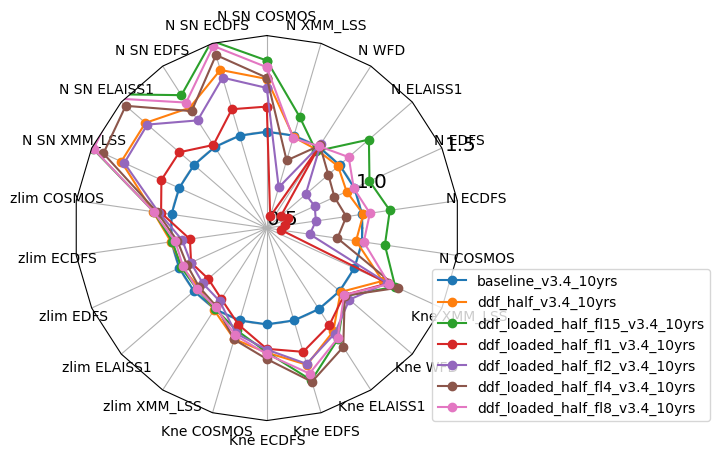

In [35]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

In [36]:

sub_mag




g          i          r          u  \
retro_baseline_v2.0_10yrs  26.835006  26.308518  26.850968  25.707301   
baseline_v2.0_10yrs        26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs        26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs        26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs        26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs        26.678103  26.295888  26.807880  25.622696   
baseline_v3.3_10yrs        26.786124  26.451047  26.929058  25.338704   
baseline_v3.4_10yrs        26.787692  26.447680  26.937429  25.336256   

                                   y          z  
retro_baseline_v2.0_10yrs  24.842363  25.606168  
baseline_v2.0_10yrs        24.762720  25.510379  
baseline_v2.1_10yrs        24.728145  25.486640  
baseline_v2.2_10yrs        24.782743  25.581317  
baseline_v3.0_10yrs        24.756955  25.524781  
baseline_v3.2_10yrs        24.766647  25.586860  
baseline_v3.3_10yrs        24.805181  25.748060  
baseline_v3.4_10yrs        24.813212  25.750017

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_13020/2717096801.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',


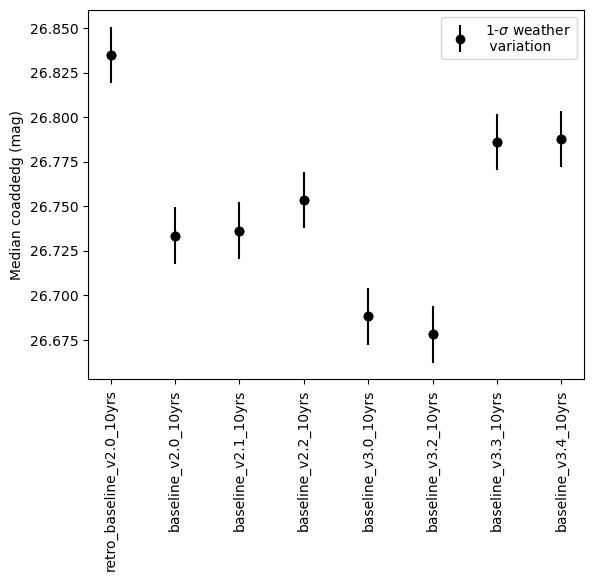

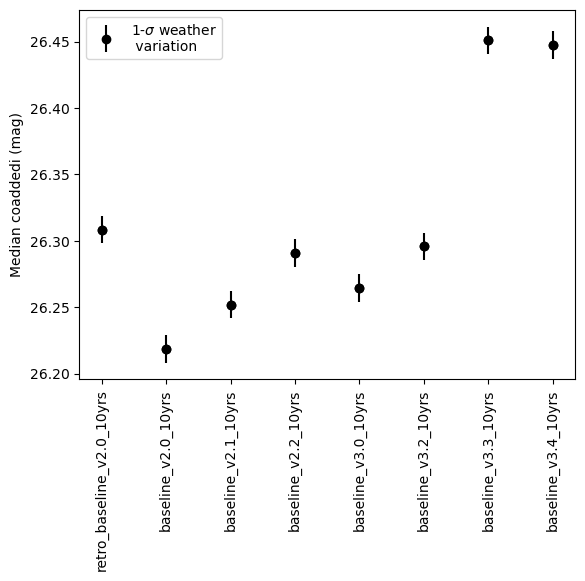

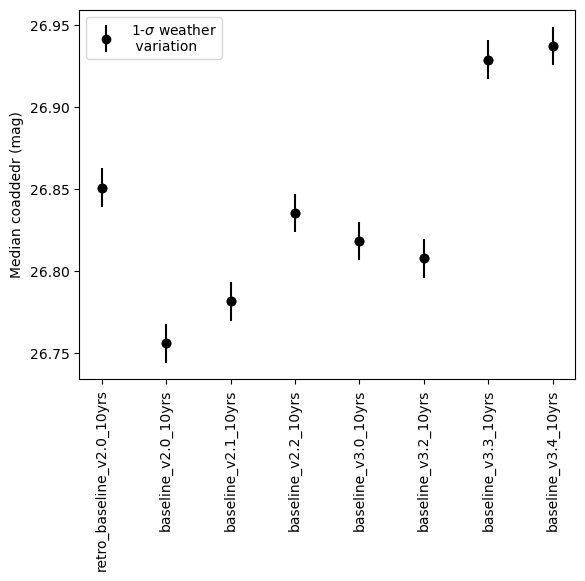

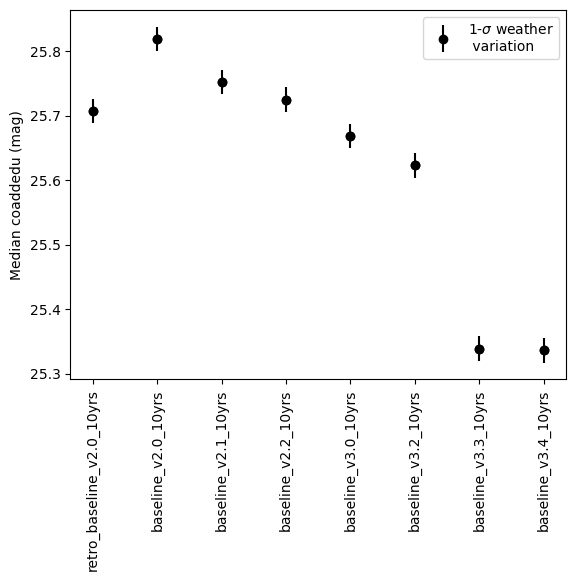

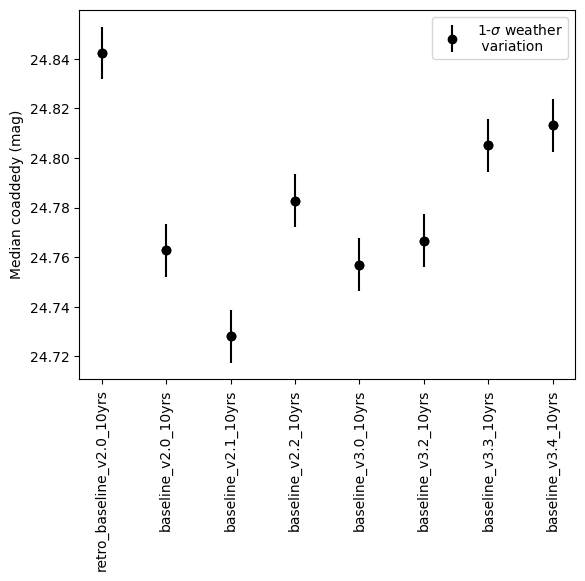

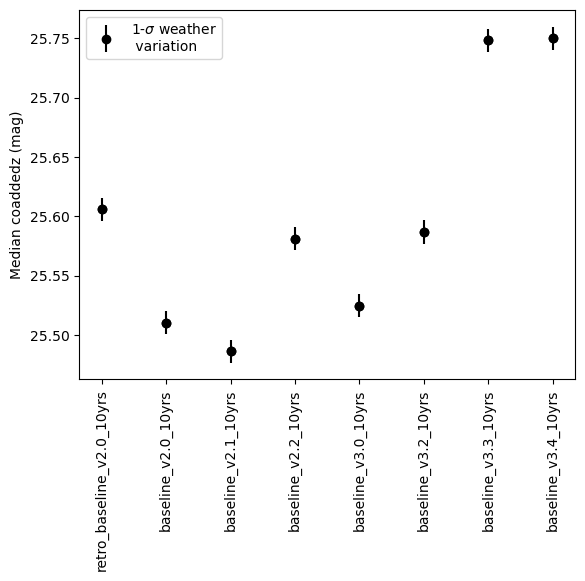

In [37]:
# Rough error bars from weather simulations

#col = data.columns[0]
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    
    label_add = ' (mag)'
    ax.set_ylabel('Median coadded' + col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [38]:
[col for col in data_loaded.columns if 'MBA' in col and 'Inversion' in col and 'H = 18.0' in col]

['FractionPop Lightcurve Inversion H = 18.000000 LightcurveInversionAsteroid MBA MoObjSlicer']

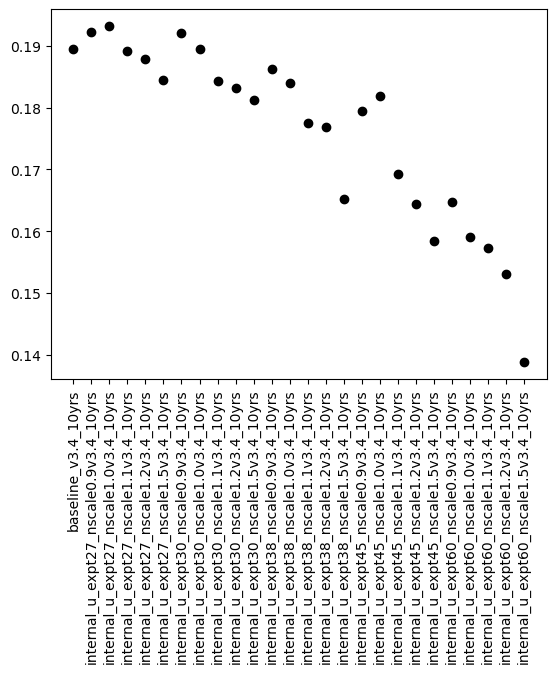

In [39]:

runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]
fig, ax = plt.subplots()
ax.plot(data_loaded['FractionPop Lightcurve Inversion H = 18.000000 LightcurveInversionAsteroid MBA MoObjSlicer'].loc[runs],
       'ko')
ax.tick_params(axis='x', labelrotation = 90)
